# Income Patterns, through Ecological Regression

## Setup

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="cccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf, !is.na(med_inc)) %>%
    mutate(fips = fips_code) %>% select(-fips_code)

In [4]:
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

[1] "$36,550.54"

[1] "$84,242.34"

[1] "$158,490"

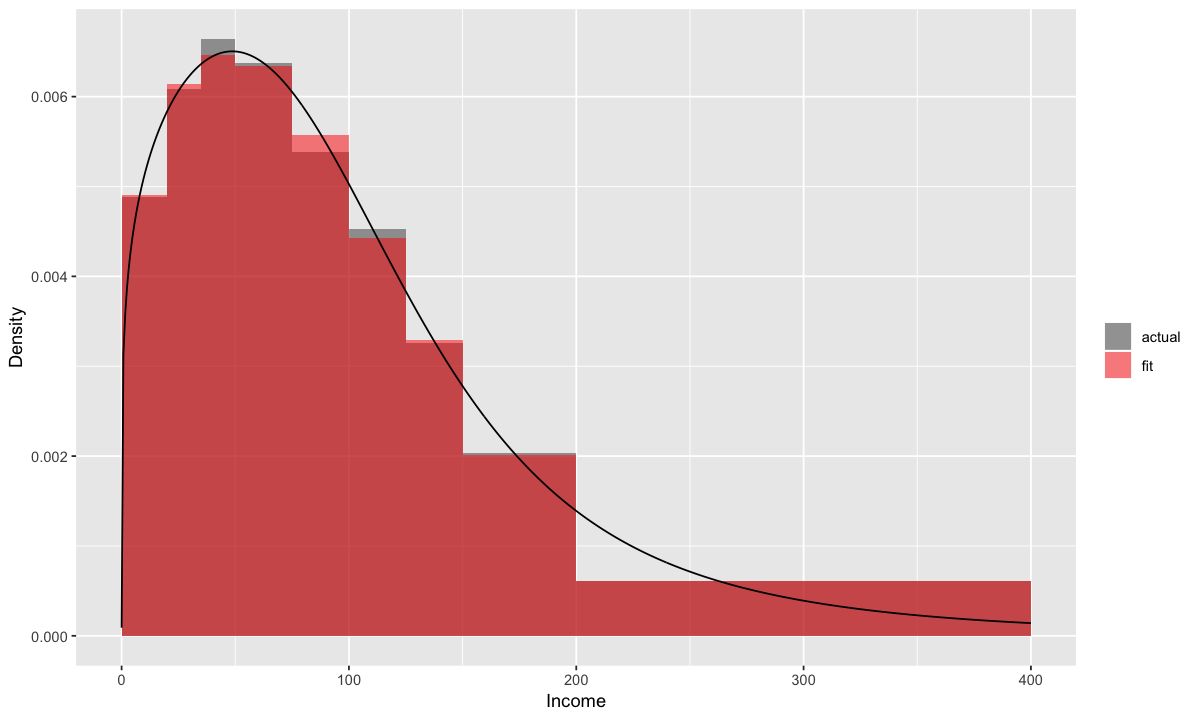

In [5]:
metro_counts = acs %>% 
    mutate(group="Metro") %>%
    filter(county_name %in% c("King", "Snohomish")) %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_metro = fit_dagum(metro_counts$count, acs_bins)

plot(fit_metro, 400)
scales::dollar(1000*qinc(0.2, fit_metro))
scales::dollar(1000*median(fit_metro))
scales::dollar(1000*qinc(0.8, fit_metro))

A fitted Dagum distribution with b = 121.38, a = 2.8, and p = 0.43

4833041 total observation(s)
Bins: 0 20 35 50 75 100 125 150 200 Inf


[1] "$74,020.37"

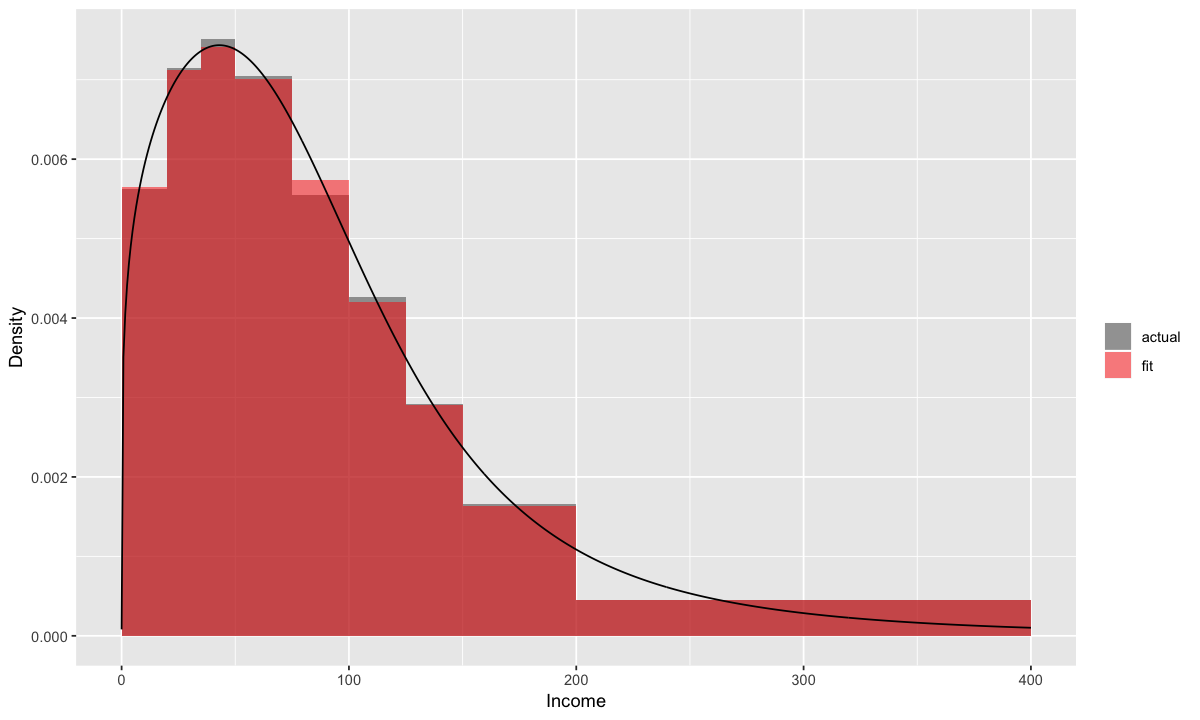

In [6]:
all_counts = acs %>% 
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_all = fit_dagum(all_counts$count, acs_bins)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]

print(fit_all)
plot(fit_all, 400)
scales::dollar(1000*median(fit_all))

In [7]:
db_path = "../../../data/hot.db"
trips = load_table(db_path, "trips_linked")
acct_stats = load_table(db_path, "acct_stats")

In [8]:
fix_time = function(t) {
    t = as_datetime(t)
    if_else(t < 1520733600 | t > 1541296800, t - 3600, t)
}

In [9]:
trips.2pct = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute %>%
    mutate(fips=as.character(fips),
           entry_time=fix_time(entry_time))

Warning message:
“Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two.”Warning message:
“11 parsing failures.
   row col               expected actual         file
 37249 zip a double               V3W7X4 literal data
 37787 zip no trailing characters LY     literal data
 46162 zip a double               V3W7X4 literal data
123282 zip a double               V3W7X4 literal data
132178 zip a double               V3W7X4 literal data
...... ... ...................... ...... ............
See problems(...) for more details.
”

## Overall distribution

In [10]:
trips.2pct %>%
    filter(commercial==0) %>%
    block_counts_by(commercial, acs, type="users") %>%
    fit_ecolg %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all, N=50000)#  %>% plot_inc_distr

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients


commercial,est_10,est_25,est_50,est_75,est_90,count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,35296.45,62403.67,104565,168469.1,273933.5,64772.91


In [11]:
o.m = trips.2pct %>%
    filter(commercial==0) %>%
    block_counts_by(commercial, acs, type="users") %>%
    fit_ecolg

pdf.inc = function(x) dinc(x, fit_all) * exp(fixef(o.m)[1] + fixef(o.m)[2]*log(x/1e3))
norm.const = integrate(pdf.inc, 0.001, 1e3)$value
cdf.inc = Vectorize(function(x) integrate(pdf.inc, 0.001, x)$value/norm.const)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients


In [12]:
cdf.inc(200)

[1] 0.8208712

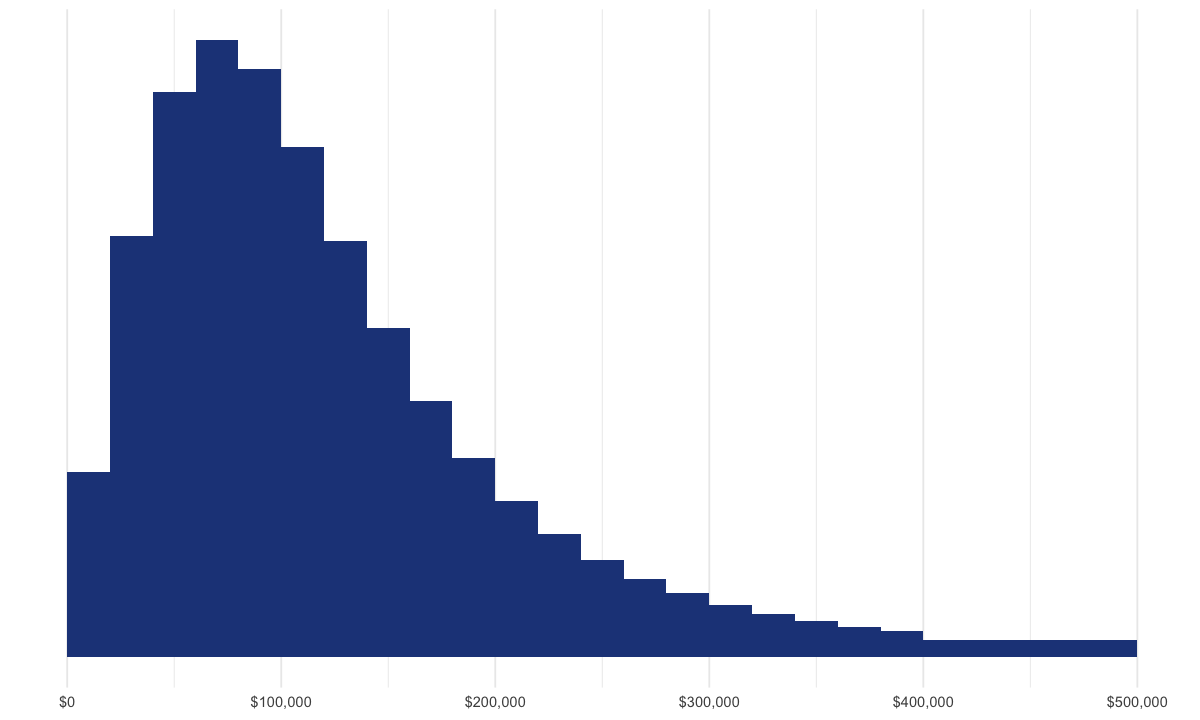

In [329]:
tibble(low = seq(0, 400, 20),
       high = c(low[-1], 500)) %>%
    mutate(pct = cdf.inc(high) - cdf.inc(low)) %>%
ggplot(aes(xmin=low*1000, xmax=high*1000, ymin=0, ymax=pct/(high-low))) + 
    geom_rect(fill="#224488") +
    scale_x_continuous(labels=scales::dollar) +
    theme_minimal() +
    theme(panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_blank())

ggsave("../../../img/inc_distr_users.png", width=6.5, height=3, dpi=320)

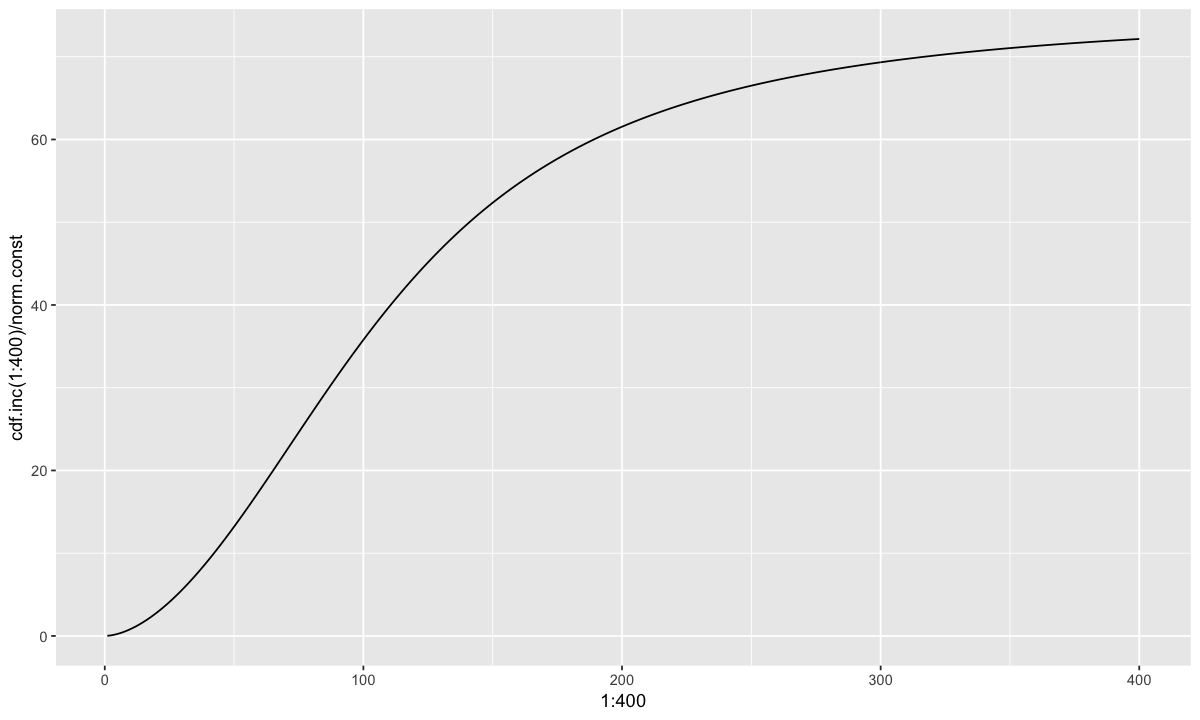

In [306]:
qplot(1:400, cdf.inc(1:400)/norm.const, geom='line')

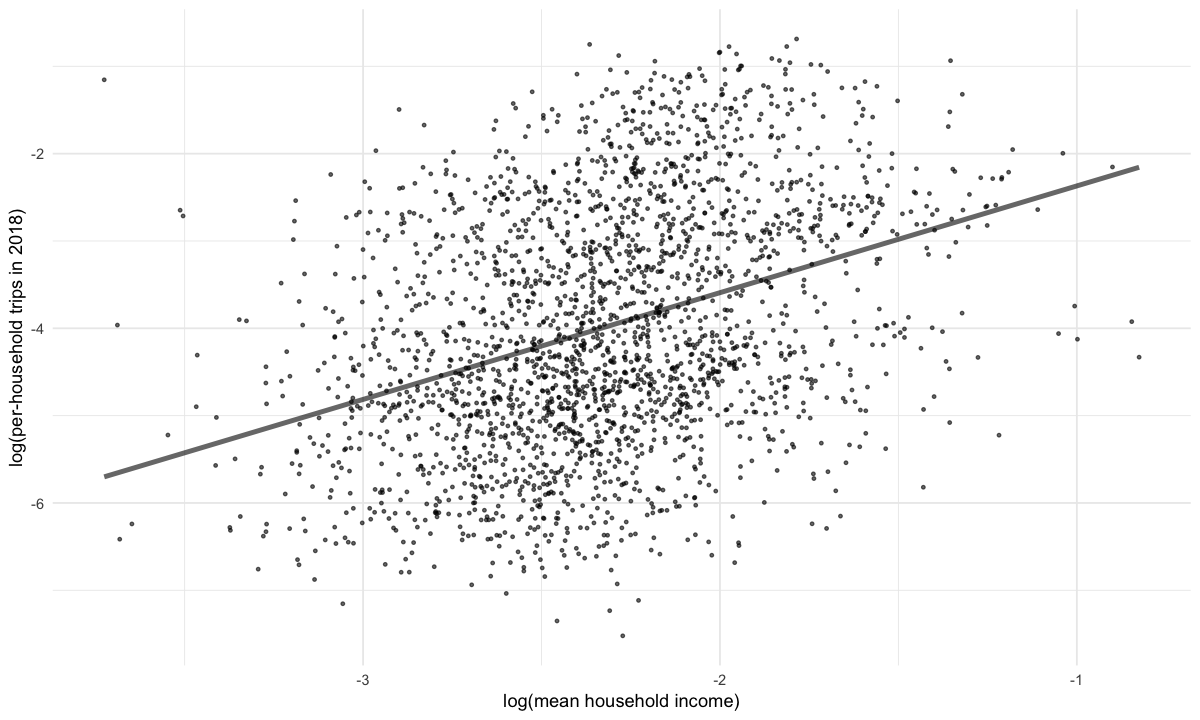

In [48]:
trips.2pct %>%
    filter(commercial==0) %>%
    block_counts_by(commercial, acs, type="users") %>%
    mutate(county = str_sub(fips, 4, 5)) %>%
    group_by(tract) %>%
    mutate(slope=coef(lm(log(hh_income) ~ log(hh_counts)))[2]) %>%
    drop_na(slope) %>%
ggplot(aes(log(hh_income), log(hh_counts))) +#, color=fct_rev(county), group=county)) +
    geom_point(alpha=0.6, size=0.7) +
    labs(x="log(mean household income)", y="log(per-household trips in 2018)") +
    #scale_color_viridis_d(end=0.9) + guides(color=F) +
    theme_minimal() +
    stat_smooth(geom="line", method=lm, lwd=1.4, alpha=0.6, se=F)#, color="#222222")

ggsave("../../../img/eco2.png", width=6, height=3, dpi=320)

In [158]:
trips.2pct %>%
    group_by(is_hov) %>%
    mutate(total=n()) %>%
    ungroup() %>%
    group_by(is_hov, !is.na(fips), !is.na(id)) %>%
    summarize(count=n(), pct=count/mean(total), total=mean(total))

is_hov,!is.na(fips),!is.na(id),count,pct,total
<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>
0,FALSE,FALSE,28616,0.1617674,176896
0,FALSE,TRUE,46625,0.2635729,176896
0,TRUE,TRUE,101655,0.5746597,176896
1,FALSE,FALSE,18839,0.2577014,73104
1,TRUE,TRUE,54265,0.7422986,73104


## By Frequency

In [159]:
table(trips.2pct$freq)


 1_single 2_monthly  3_weekly 4_regular   5_daily    6_high 
     5886     41484     40794     45665     47380     21336 

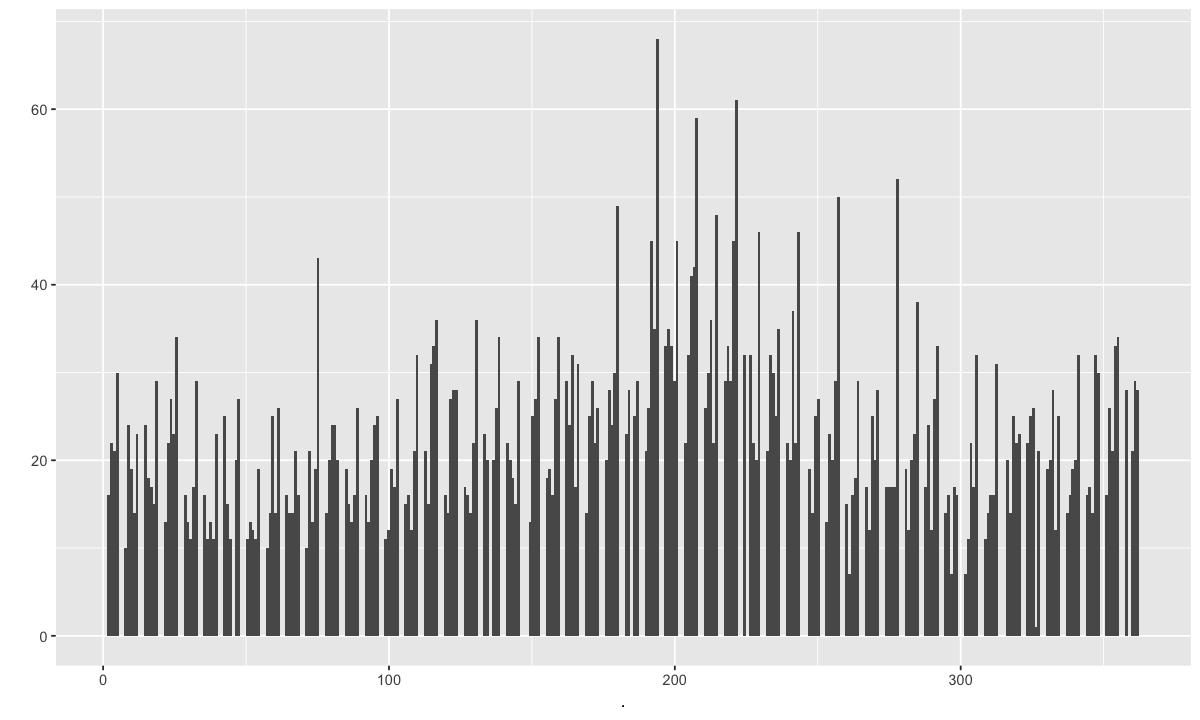

In [172]:
trips.2pct %>%
    filter(freq=="1_single") %>%
    mutate(yday=yday(entry_time)) %>%
    pull %>%
    qplot(bins=365)

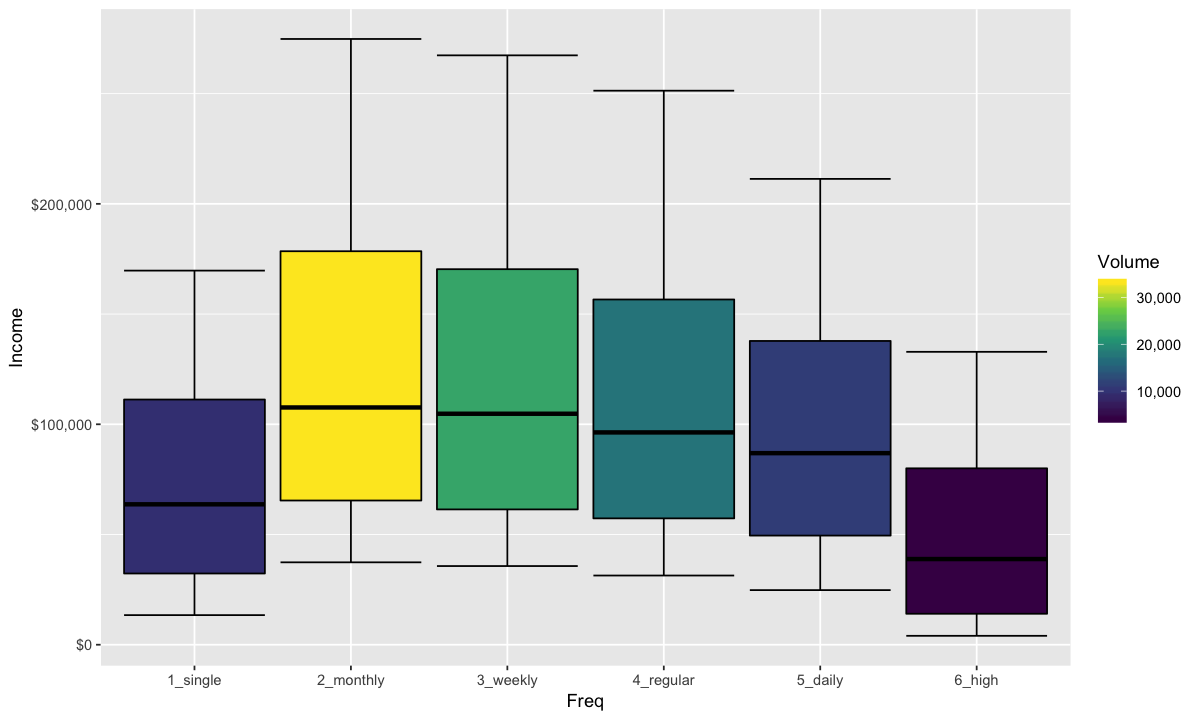

In [173]:
trips.2pct %>%
    filter(is_hov==0, commercial==0) %>%
    block_counts_by(freq, acs, type="users") %>%
    fit_ecolg %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all)  %>%
    plot_inc_distr

In [224]:
freq_counts =  acct_stats %>%
    filter(commercial == 0) %>%
    group_by(freq) %>%
    summarize(count=n()) %>%
    execute %>%
    mutate(pct = count / sum(count))

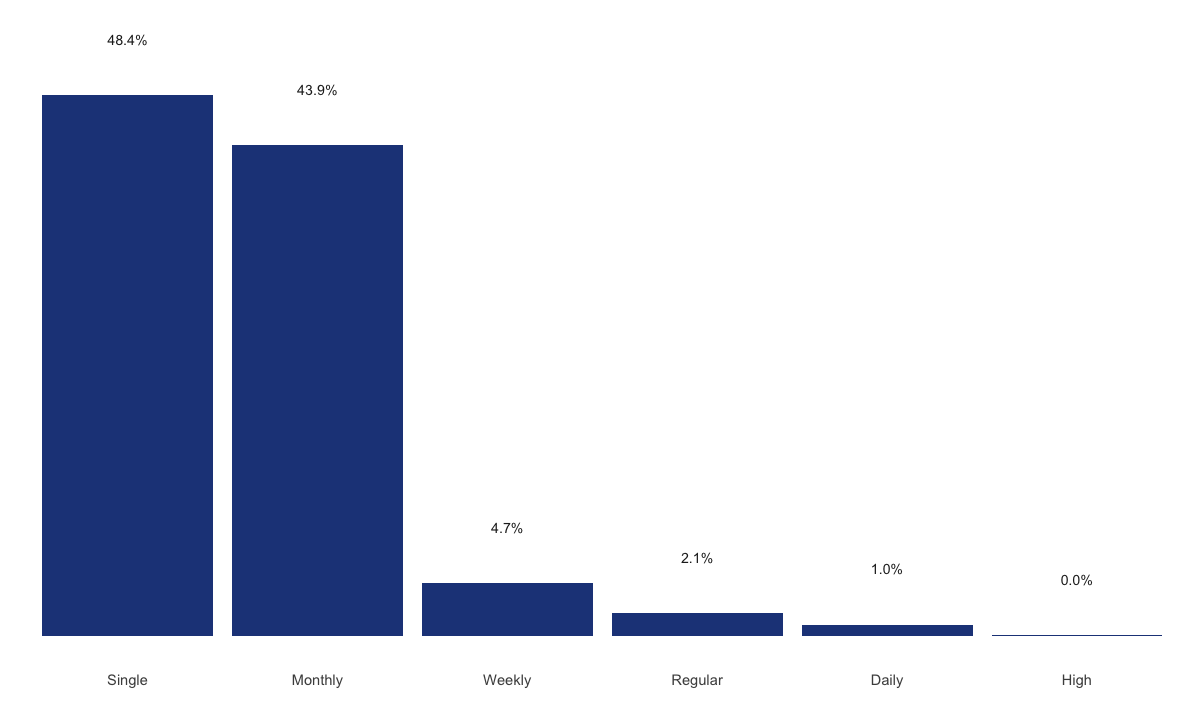

In [406]:
ggplot(freq_counts, aes(freq, pct)) +
    geom_col(fill="#224488") +
    geom_text(aes(label=scales::percent(pct)), color="#222222", nudge_y=0.05, size=3) +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    labs(x="") + guides(fill=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())
                     
ggsave("../../../img/freq_users.png", height=3, width=6.5, dpi=320)

In [417]:
freq_counts.2 = trips %>%
    select(id) %>%
    filter(!is.na(id)) %>%
    left_join(acct_stats, by="id") %>%
    group_by(freq) %>%
    summarize(count=n()) %>%
    execute %>%
    mutate(pct = count / sum(count))

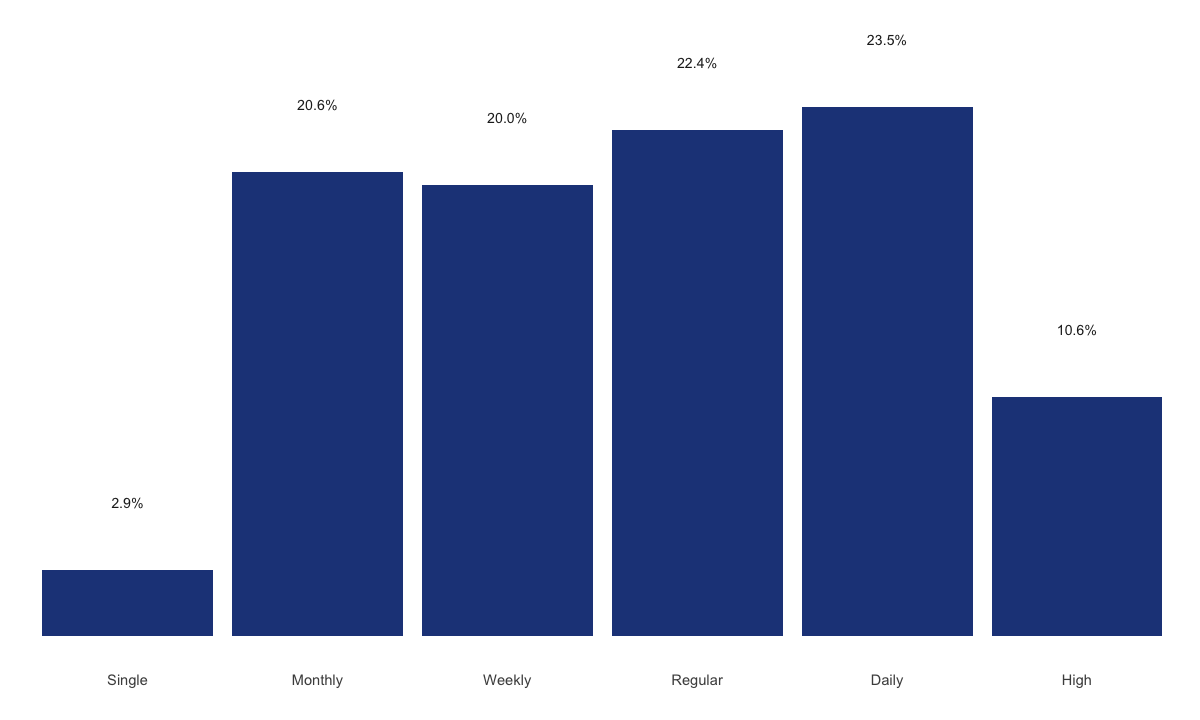

In [419]:
ggplot(freq_counts.2, aes(freq, pct)) +
    geom_col(fill="#224488") +
    geom_text(aes(label=scales::percent(pct)), color="#222222", nudge_y=0.03, size=3) +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    labs(x="") + guides(fill=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())
                     
ggsave("../../../img/freq_trips.png", height=3, width=6.5, dpi=320)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00349701 (tol = 0.002, component 1)”

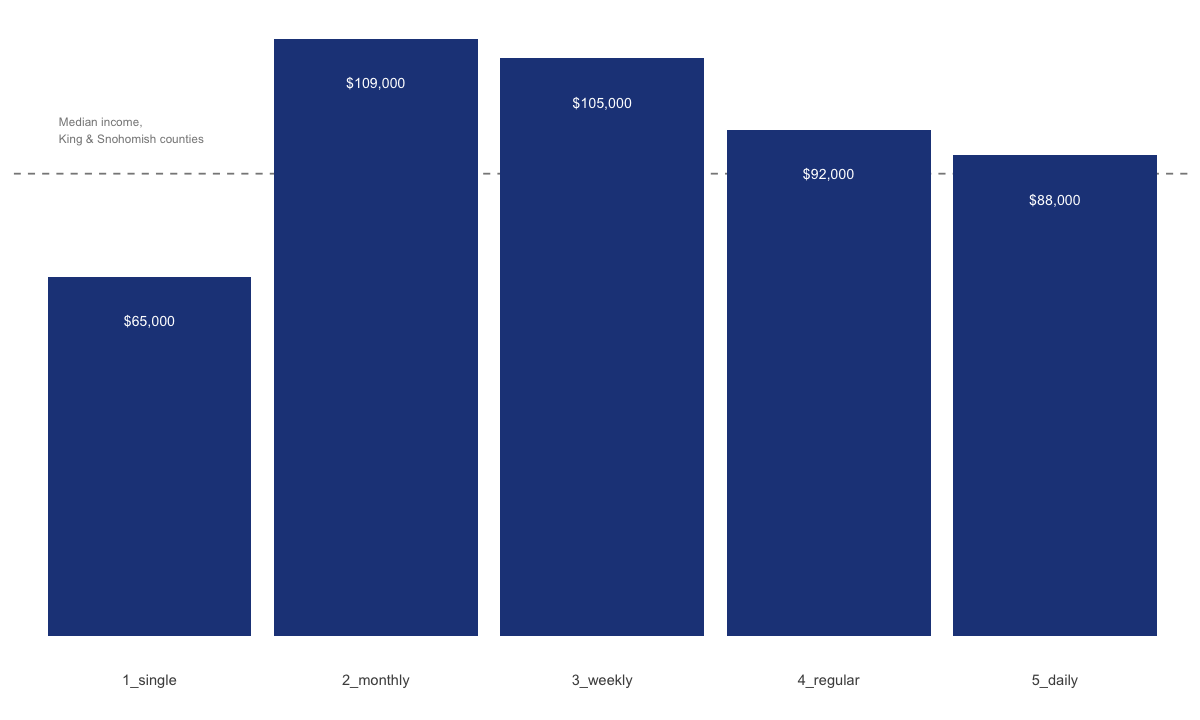

In [434]:
trips.2pct %>%
    filter(is_hov==0, commercial==0, !is.na(freq), freq != "6_high") %>%
    #mutate(freq=if_else(freq=="1_single", "One-time", "Others")) %>%
    block_counts_by(freq, acs, type="users") %>%
    fit_ecolg %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>%
    #left_join(freq_counts, by="freq")# %>%
ggplot(aes(freq, est_50)) +
    geom_hline(yintercept=1e3*median(fit_metro), lty="dashed", color="#888888") +
    annotate("text", label="Median income,\nKing & Snohomish counties", 
             x=0.6, y=1e3*(median(fit_metro)+8), hjust="left", size=2.5, color="#888888") +
    geom_col(fill="#224488") +
    geom_text(aes(label=scales::dollar(round(est_50/1e3)*1e3)), color="white", nudge_y=-8000, size=3) +
    #scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    scale_x_discrete() +
    labs(x="") + guides(fill=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())
                     
ggsave("../../../img/inc_freq_3.png", height=3, width=6.5, dpi=320)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00293444 (tol = 0.002, component 1)”

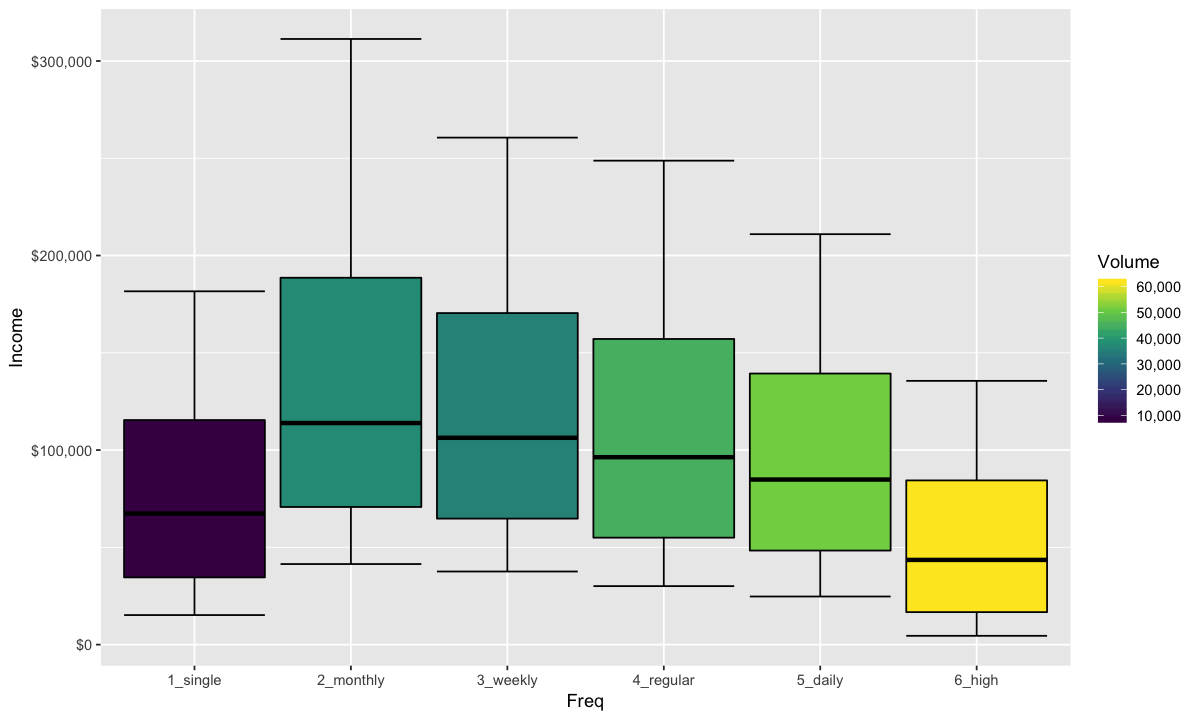

In [248]:
    block_counts_by(trips.2pct, freq, acs, type="trips") %>%
    fit_ecolg %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all)  %>%
    elot_inc_distr

In [193]:
facet_med_inc = function(df, group_var, facet_var, ...) {
    group_var = enquo(group_var)
    facet_var = enquo(facet_var)
    dfs = group_split(df, !!facet_var)
    
    plots = list()
    for (d in 1:length(dfs)) {
        plots[[d]] = block_counts_by(dfs[[d]], !!group_var, acs, ...) %>%
            fit_ecolg %>%
            ecolg_quantiles(0.5, fit_all)  %>%
            mutate(county = dfs[[d]]$county[1],
                   cty_inc = dfs[[d]]$cty_inc[1])
    }
    
    bind_rows(plots)
}

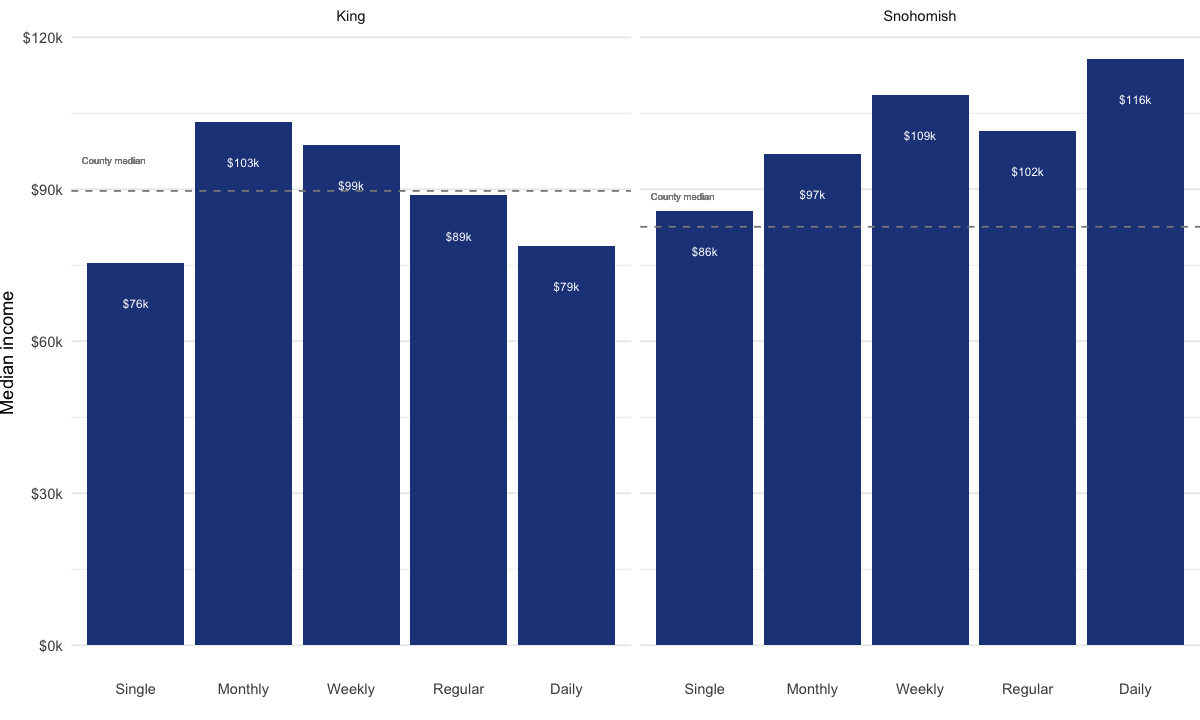

In [204]:
trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry_plaza-2, entry_plaza-12),
           exit = if_else(direction=="NB", exit_plaza-2, exit_plaza-12),
           id = str_glue("{direction}_{entry}_{exit}"),
           hour = hour(entry_time),
           am_peak = hour >= 5 & hour < 9 & direction == "SB",
           pm_peak = hour >= 15 & hour < 19 & direction == "NB",
           peak = am_peak | pm_peak,
           county = str_sub(fips, 3, 5)) %>%
    filter(county == "033" | county == "061") %>%
    mutate(county = if_else(county == "033", "King", "Snohomish"),
           cty_inc = if_else(county == "King", 89675, 82595)) %>%
    filter(peak, freq != "6_high") %>%
    facet_med_inc(freq, county, type="users") %>%
ggplot(aes(freq, est_50)) +
    facet_wrap("county") +
    geom_col(fill="#224488") +
    geom_hline(aes(yintercept=cty_inc), lty="dashed", color="#888888") +
    geom_text(aes(label="County median", x=0.5, y=cty_inc+6e3),
              hjust="left", size=2, color="#888888") +
    geom_text(aes(label=paste0(scales::dollar(round(est_50/1e3)), "k")), 
              color="white", nudge_y=-8000, size=2.5) +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    scale_y_continuous(name="Median income", labels=function(x) paste0(scales::dollar(round(x/1e3)), "k")) +
    labs(x="") +
    theme_minimal() +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          plot.margin=grid::unit(c(0,0,0,0), "mm"))
                       
ggsave("../../../img/inc_freq_county.png", width=6.5, height=3, dpi=320)

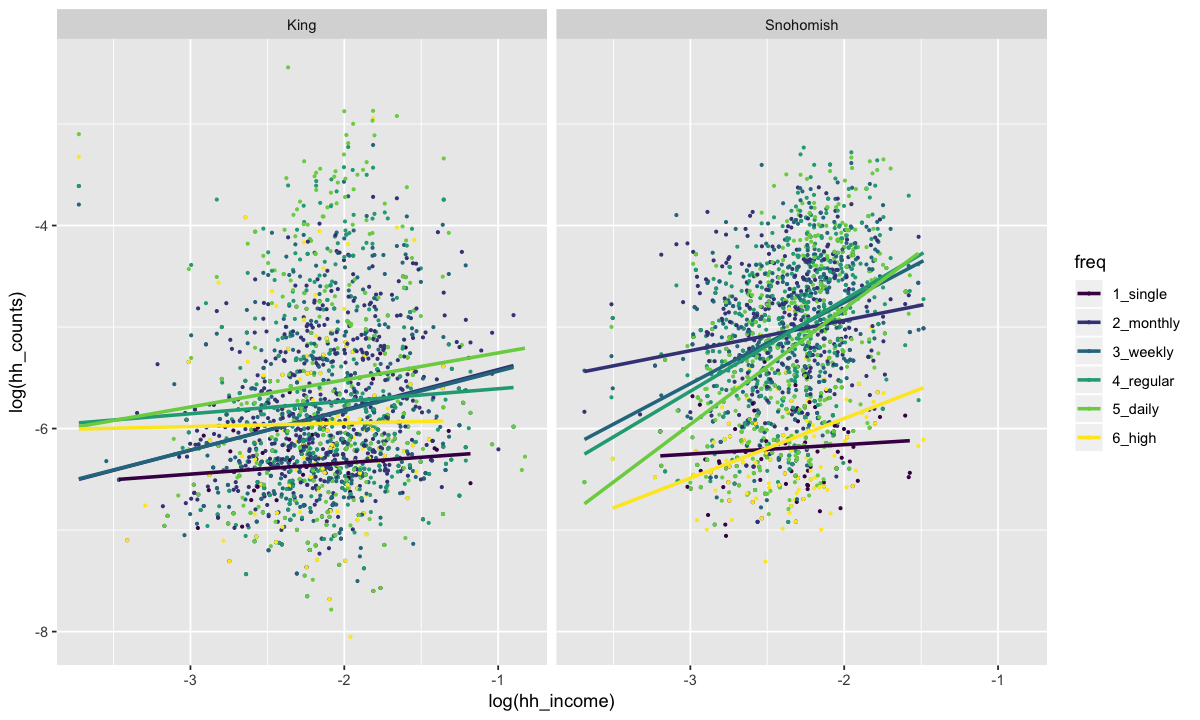

In [213]:
fips_trips = filter(trips.2pct, toll >= 5) %>%
    block_counts_by(freq, acs, type="users")  %>% 
    left_join(acs, by="fips") %>%
    filter(county_name %in% c("King", "Snohomish"))
ggplot(fips_trips, aes(log(hh_income), log(hh_counts), color=freq)) + 
    facet_wrap("county_name") +
    geom_point(size=0.5) +
    geom_smooth(method=lm, se=F) +
    scale_color_viridis_d()

## By Toll

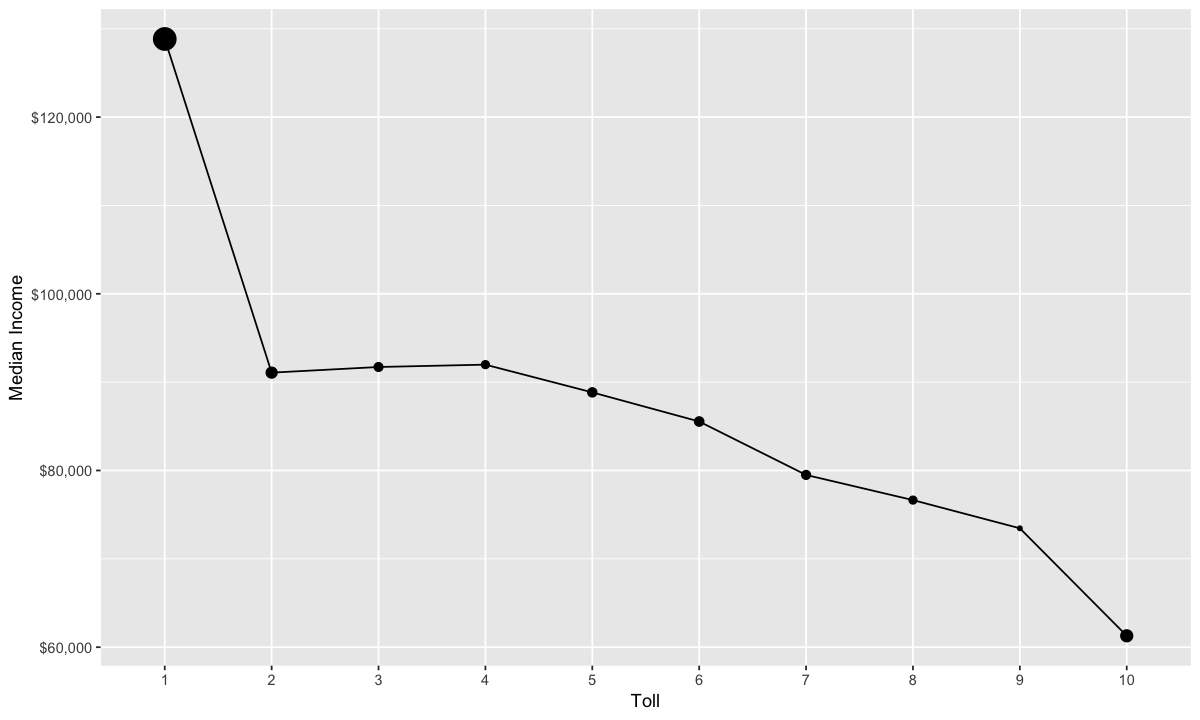

In [71]:
trips.2pct %>%
    filter(is_hov == 0) %>%
    mutate(toll = as.factor(ceiling(toll)),
           hour = hour(as_datetime(entry_time)),
           county = str_sub(fips, 3, 5)) %>%
    block_counts_by(toll, acs) %>%
    fit_ecolg(vary_slopes=T) %>%
    ecolg_quantiles(0.5, fit_all) %>% 
    plot_med_inc

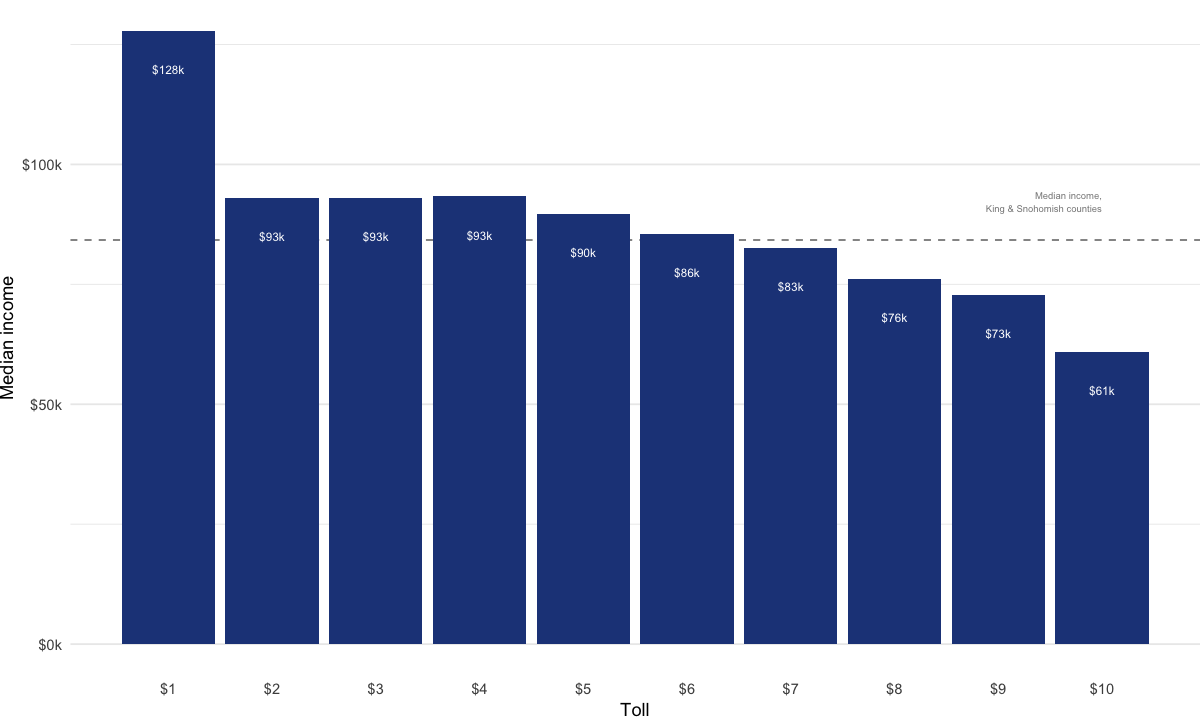

In [178]:
trips.2pct %>%
    filter(is_hov == 0) %>%
    mutate(toll = as.factor(ceiling(toll)),
           hour = hour(as_datetime(entry_time)),
           county = str_sub(fips, 3, 5)) %>%
    block_counts_by(toll, acs) %>%
    fit_ecolg(vary_slopes=T) %>%
    ecolg_quantiles(0.5, fit_all) %>% 
    mutate(toll = as.numeric(toll)) %>%
ggplot(aes(toll, est_50)) +
    geom_hline(yintercept=1e3*median(fit_metro), lty="dashed", color="#888888") +
    annotate("text", label="Median income,\nKing & Snohomish counties", 
             x=10, y=1e3*(median(fit_metro)+8), hjust="right", size=2, color="#888888") +
    geom_col(fill="#224488") +
    geom_text(aes(label=paste0(scales::dollar(round(est_50/1e3)), "k")), 
              color="white", nudge_y=-8000, size=2.5) +
    scale_y_continuous(name="Median income", labels=function(x) paste0(scales::dollar(round(x/1e3)), "k")) +
    scale_x_continuous(breaks=1:10, labels=scales::dollar) +
    labs(x="Toll") + guides(fill=F) +
    #annotate("text", label="Median income of drivers by toll", size=4, x=10, y=120e3, hjust="right") +
    theme_minimal() +
    theme(#panel.grid = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          #axis.text.y = element_blank(),
          #axis.title.y = element_blank(),
          plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/inc_toll.png", height=3, width=6.5, dpi=320)

In [90]:
toll.d = trips.2pct %>%
    filter(is_hov == 0) %>%
    mutate(toll = as.factor(ceiling(toll)),
           hour = hour(as_datetime(entry_time)),
           county = str_sub(fips, 3, 5)) %>%
    block_counts_by(toll, acs)

In [104]:
summary(
    resid(lm(log(hh_counts) ~ log(hh_income)*toll, data=toll.d)) / 
    resid(lmer(log(hh_counts) ~ log(hh_income)*toll + (1|tract), data=toll.d))
)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-278999.71      -0.40       1.17      -1.72       2.73  274218.92 

The toll-income pattern disappears into noise when we look at a single trip, and drivers originating in a single county.  So most of the toll-income pattern is likely explained by geography.

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00212556 (tol = 0.002, component 1)”

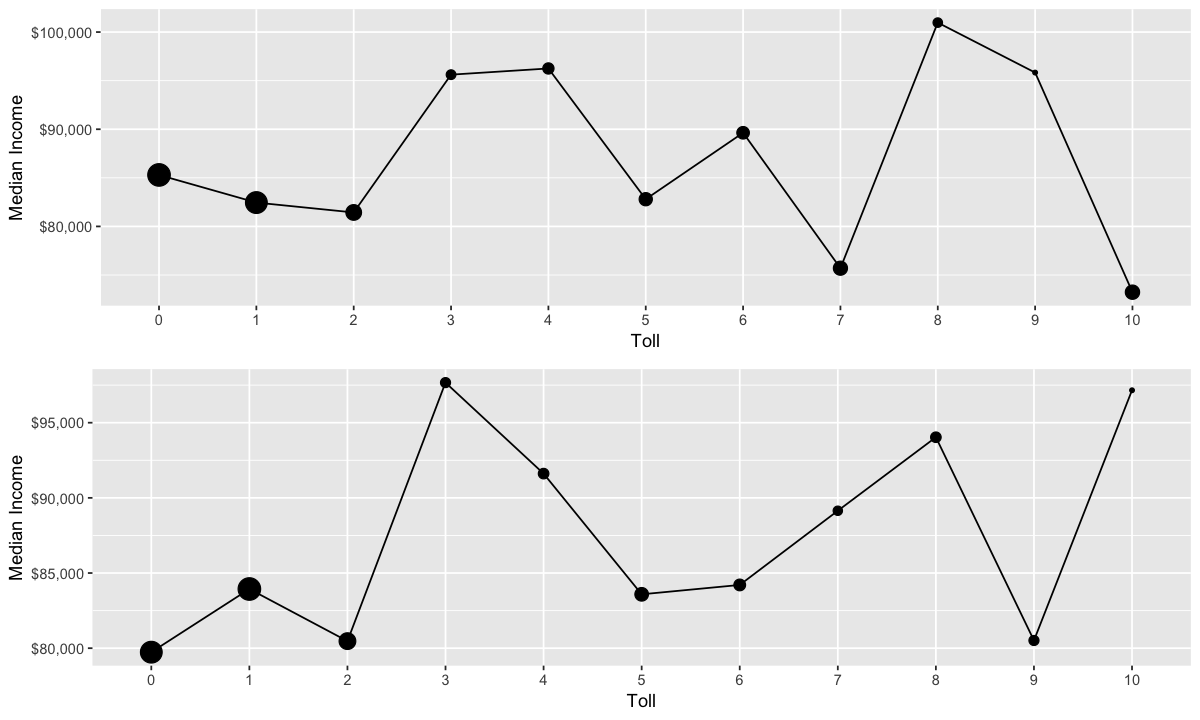

In [135]:
p_test1 = trips.2pct %>%
    mutate(toll = as_factor(ceiling(toll)),
           hour = hour(as_datetime(entry_time)),
           county = str_sub(fips, 3, 5)) %>%
    filter(entry_plaza==3, exit_plaza==6, county=="033") %>%
    block_counts_by(toll, acs) %>%
    fit_ecolg(vary_slopes=T) %>%
    ecolg_quantiles(0.5, fit_all) %>% 
    plot_med_inc

p_test2 = trips.2pct %>%
    mutate(toll = as_factor(ceiling(toll)),
           hour = hour(as_datetime(entry_time)),
           county = str_sub(fips, 3, 5)) %>%
    filter(entry_plaza==16, exit_plaza==22, county=="033") %>%
    block_counts_by(toll, acs) %>%
    fit_ecolg(vary_slopes=T) %>%
    ecolg_quantiles(0.5, fit_all) %>% 
    plot_med_inc

gridExtra::grid.arrange(p_test1, p_test2, nrow=2)

## By Hour of Day

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

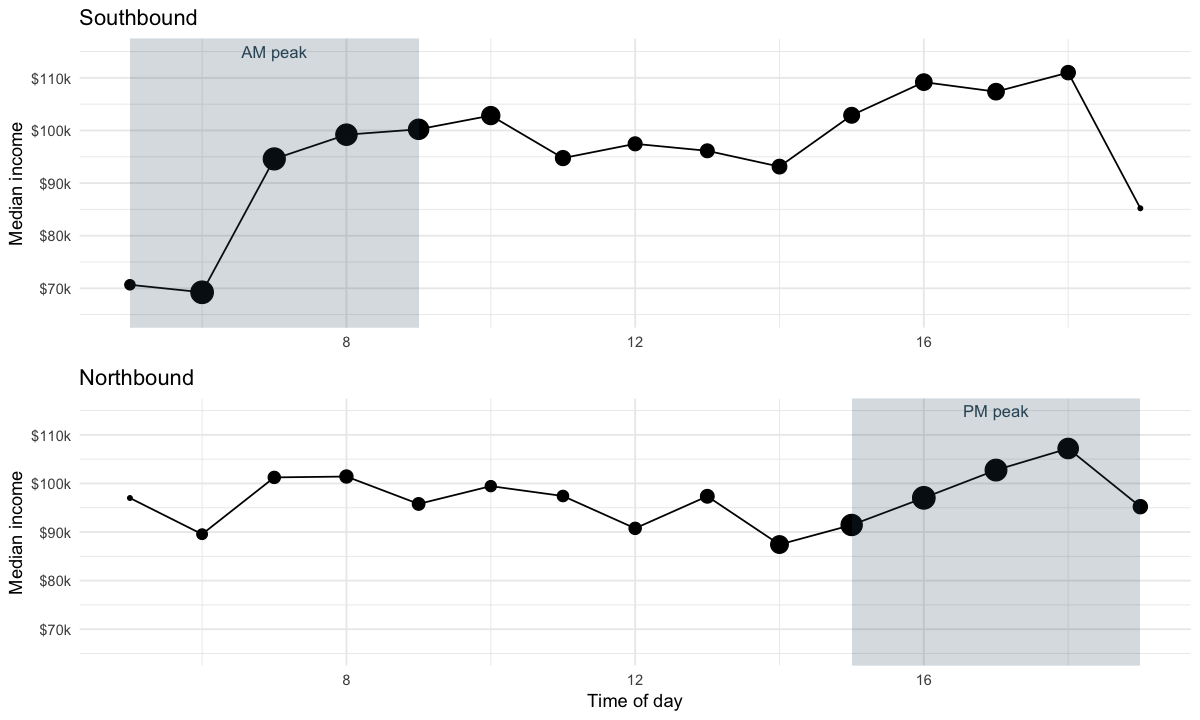

In [154]:
p_NB = trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           time_of_day = as.character(hour(entry_time) + round(minute(entry_time)/60)/1)) %>%
    filter(commercial == 0, is_hov == 0, direction == "NB") %>%
    block_counts_by(time_of_day, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all, N=10000) %>% 
    mutate(time_of_day = parse_number(as.character(time_of_day))) %>%
plot_med_inc() + 
    labs(title="Northbound", x="Time of day", y="Median income") +
    theme_minimal() +
    scale_y_continuous(name="Median income", limits=c(65e3, 115e3),
                       labels=function(x) paste0(scales::dollar(round(x/1e3)), "k")) +
    annotate("rect", xmin=15, xmax=19, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("text", x=17, y=115e3, label="PM peak", size=3.5, color="#335566")

p_SB = trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           time_of_day = as.character(hour(entry_time) + round(minute(entry_time)/60)/1)) %>%
    filter(commercial == 0, is_hov == 0, direction == "SB") %>%
    block_counts_by(time_of_day, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all, N=10000) %>% 
    mutate(time_of_day = parse_number(as.character(time_of_day))) %>%
plot_med_inc() + 
    labs(title="Southbound", x=NULL, y="Median income") +
    theme_minimal() +
    scale_y_continuous(name="Median income", limits=c(65e3, 115e3),
                       labels=function(x) paste0(scales::dollar(round(x/1e3)), "k")) +
    annotate("rect", xmin=5, xmax=9, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("text", x=7, y=115e3, label="AM peak", size=3.5, color="#335566")

p = gridExtra::grid.arrange(p_SB, p_NB, nrow=2)
p

ggsave(p, file="../../../img/inc_tod.png", height=4.5, width=6.5, dpi=320)

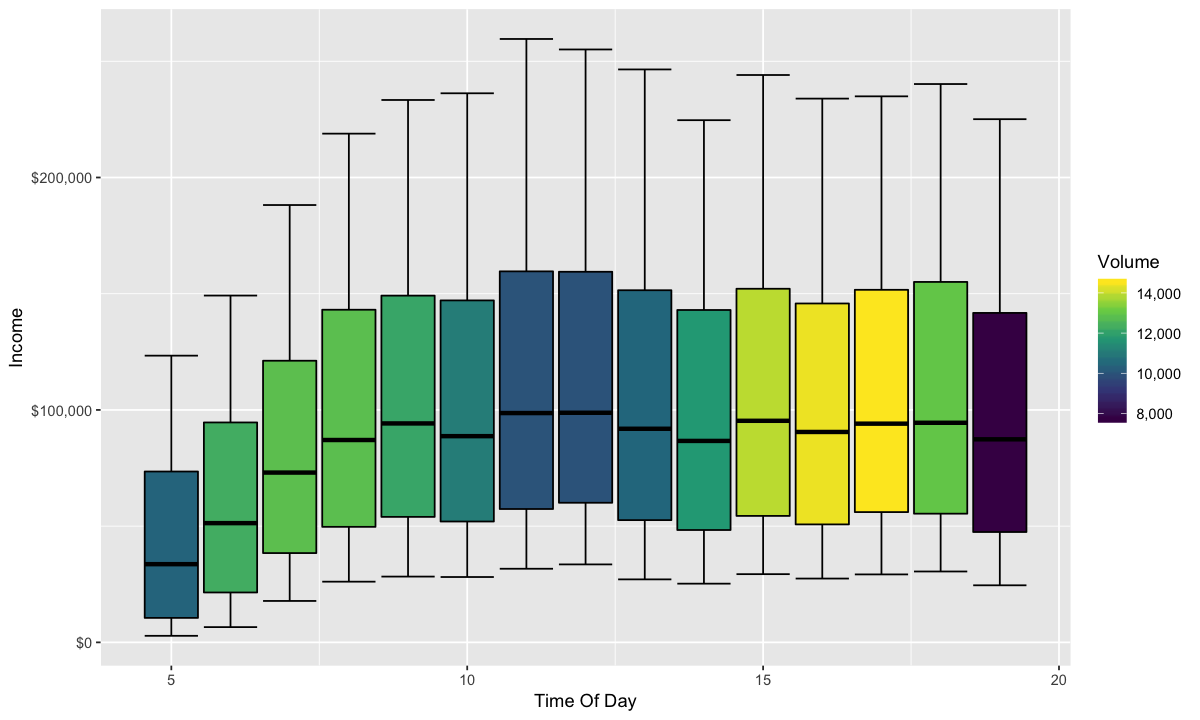

In [76]:
trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           time_of_day = as.character(hour(entry_time) + round(minute(entry_time)/60)/1)) %>%
    filter(commercial == 0, is_hov == 1) %>%
    block_counts_by(time_of_day, acs) %>%
    fit_ecolg(vary_slopes=T) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>%
    mutate(time_of_day = parse_number(as.character(time_of_day))) %>% 
plot_inc_distr

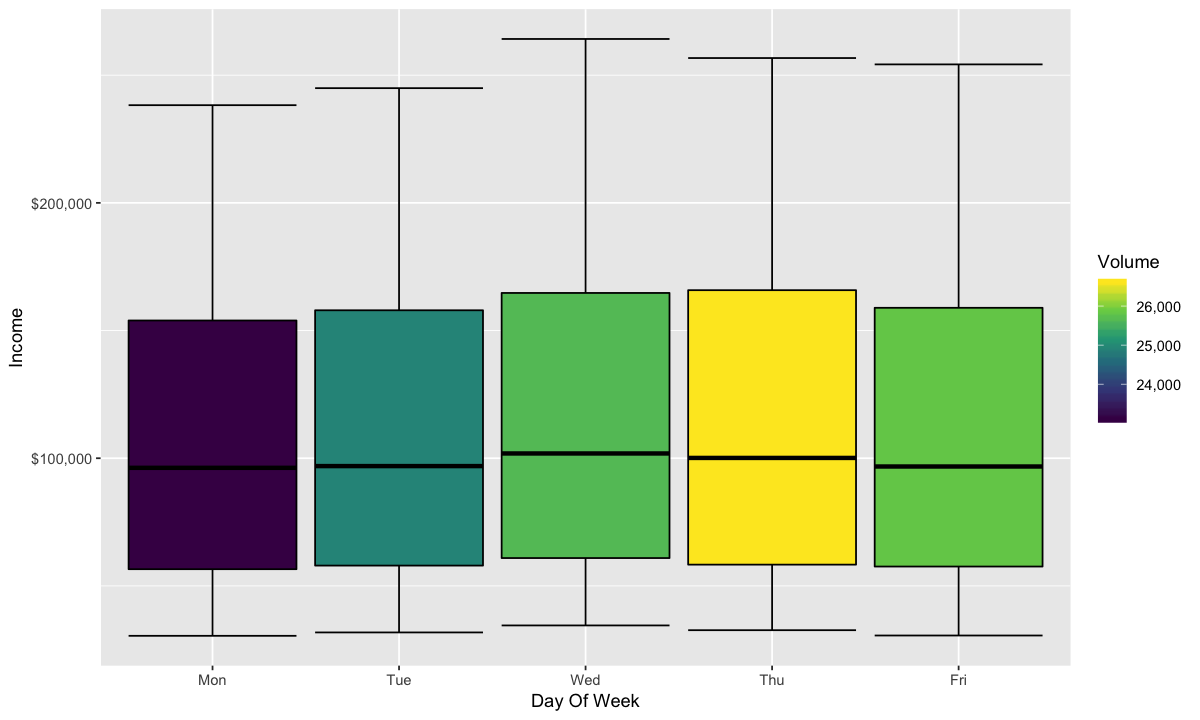

In [18]:
trips.2pct %>%
    mutate(day_of_week = wday(entry_time, label=T)) %>%
    filter(commercial == 0, is_hov == 0) %>%
    block_counts_by(day_of_week, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    plot_inc_distr

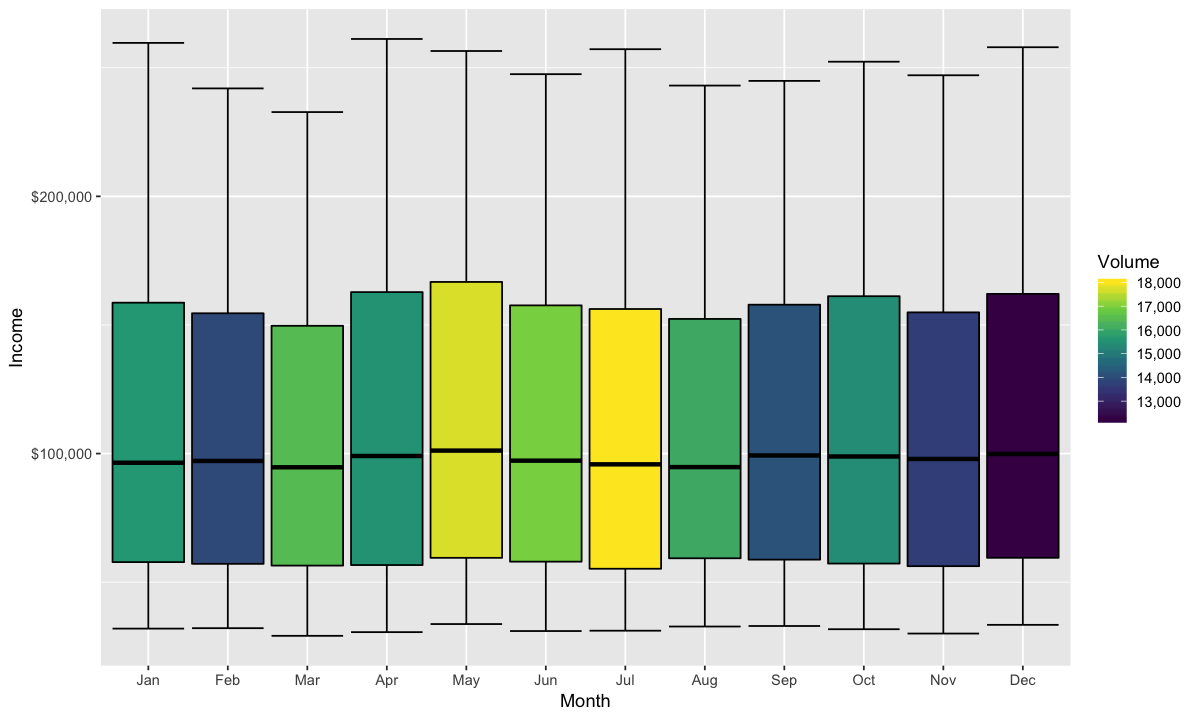

In [17]:
trips.2pct %>%
    mutate(month = month(entry_time, label=T)) %>%
    filter(commercial == 0, is_hov == 0) %>%
    block_counts_by(month, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    plot_inc_distr

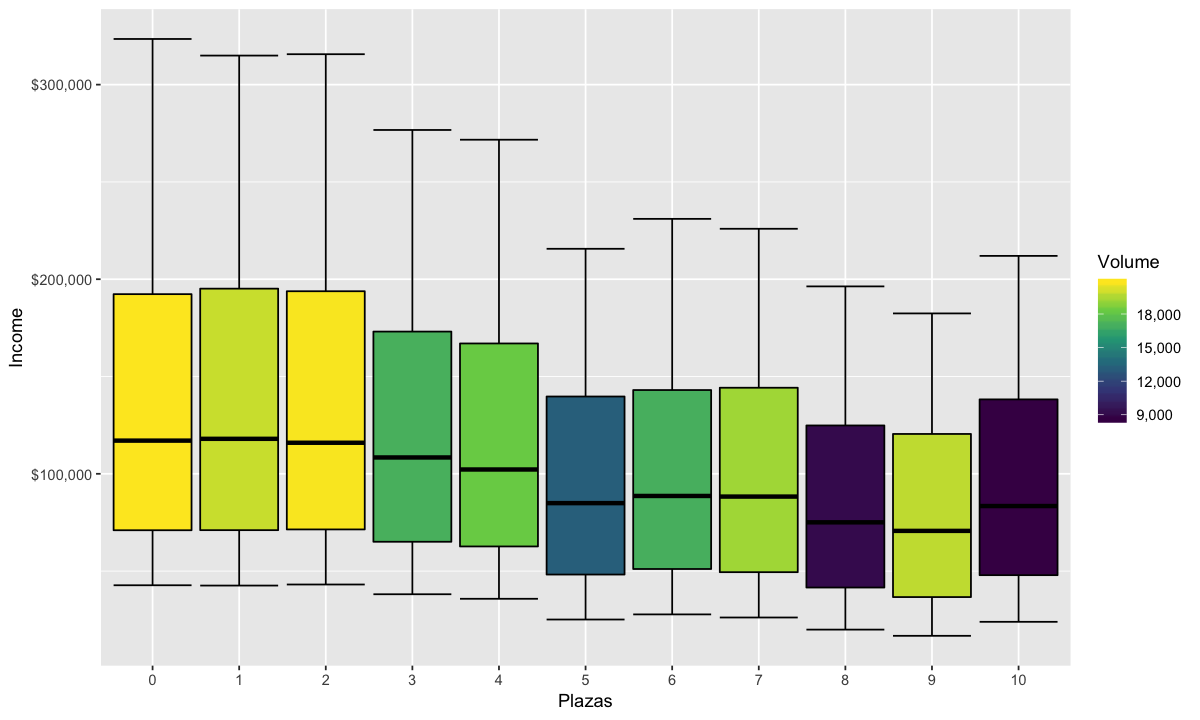

In [267]:
trips.2pct %>%
    mutate(plazas = as_factor(exit_plaza - entry_plaza)) %>%
    filter(commercial == 0, is_hov == 0) %>%
    block_counts_by(plazas, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    plot_inc_distr

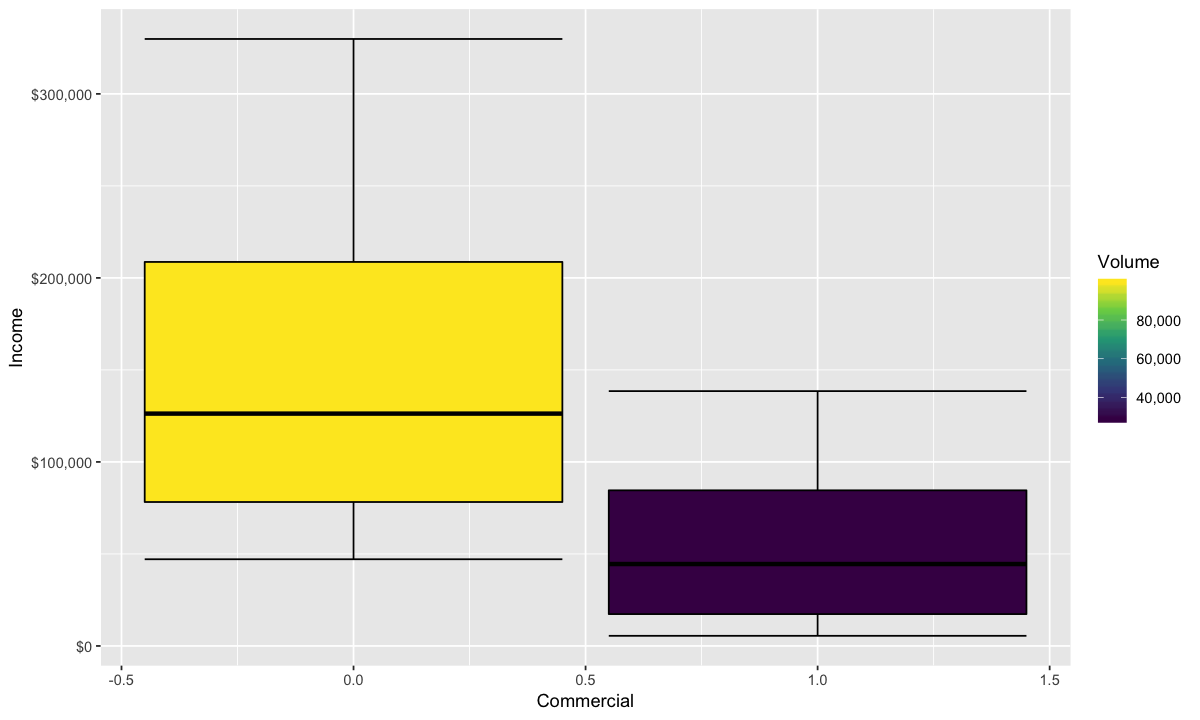

In [268]:
trips.2pct %>%
    filter(is_hov == 0) %>%
    block_counts_by(commercial, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    plot_inc_distr

In [32]:
trips.2pct %>%
    filter(commercial == 0) %>%
    select(is_hov, id) %>%
    distinct() %>%
    group_by(is_hov) %>%
    summarize(n=n())

is_hov,n
<dbl>,<int>
0,72697
1,24630


In [67]:
trips.2pct %>%
    filter(commercial == 0) %>%
    summarize(mean(is_hov))

mean(is_hov)
<dbl>
0.2781367


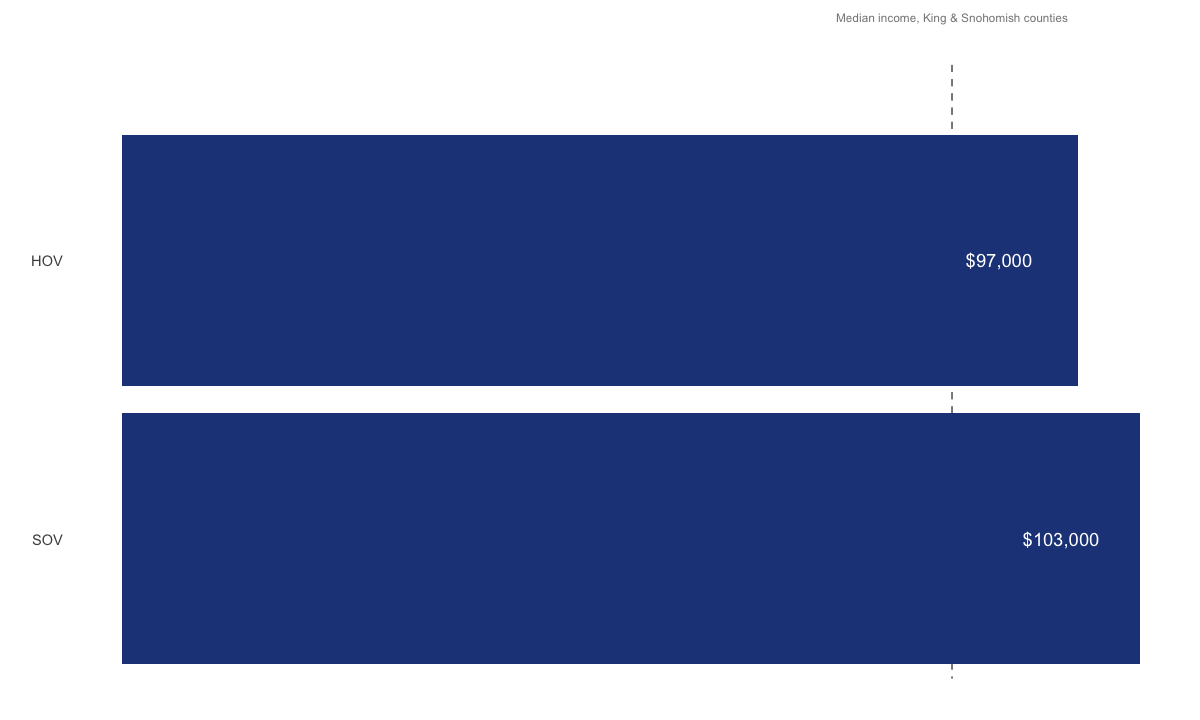

In [134]:
trips.2pct %>%
    filter(commercial == 0) %>%
    block_counts_by(is_hov, acs, type="users") %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.5), fit_all, N=50000) %>%
ggplot(aes(as_factor(is_hov), est_50)) + 
    geom_segment(x=2.7, xend=0.5, y=1e3*median(fit_metro), yend=1e3*median(fit_metro),
                 lty="dashed", color="#888888") +
    annotate("text", label="\nMedian income, King & Snohomish counties", 
             x=2.9, y=1e3*(median(fit_metro)), hjust="center", size=2.5, color="#888888") +
    geom_col(fill="#224488") + 
    scale_x_discrete(labels=c("SOV", "HOV")) +
    geom_text(aes(label=scales::dollar(round(est_50/1000)*1000)), color="white", nudge_y=-8e3) +
    #labs(title="Median income of SOV and HOV drivers", x="") + guides(fill=F) +
    labs(x="") + guides(fill=F) +
    coord_flip() +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank())

ggsave("../../../img/inc_mode.png", height=2.5, width=6.5, dpi=320)

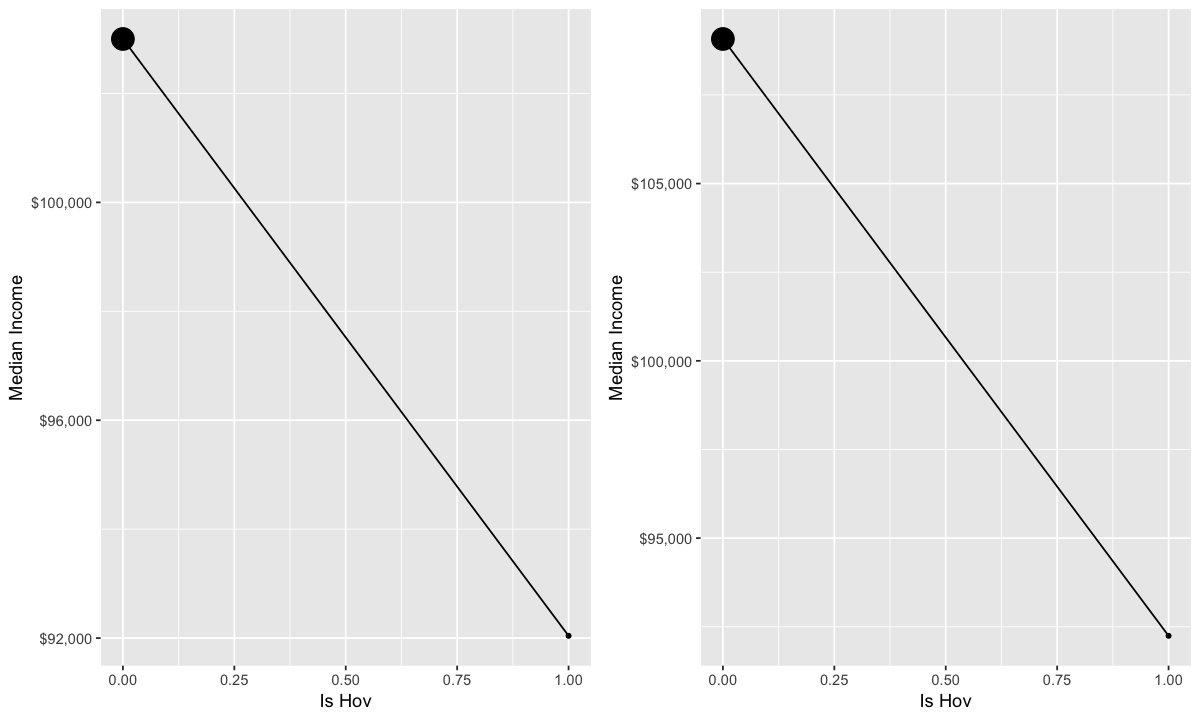

In [112]:
gridExtra::grid.arrange(
    trips.2pct %>%
        filter(commercial == 0) %>%
        block_counts_by(is_hov, acs, type="users") %>%
        fit_ecolg(vary_slopes=F) %>%
        ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
        plot_med_inc,
    trips.2pct %>%
        filter(commercial == 0) %>%
        block_counts_by(is_hov, acs, type="trips") %>%
        fit_ecolg(vary_slopes=F) %>%
        ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
        plot_med_inc,
    nrow=1)

In [16]:
trips.2pct %>%
    mutate(hour = hour(entry_time),
           direction = ifelse(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak",
                             pm_peak & direction=="NB" ~ "PM peak",
                             T ~ "Off-peak")) %>%
    group_by(peak,direction) %>%
    summarize(mean(toll==10))

peak,direction,mean(toll == 10)
<lgl>,<chr>,<dbl>
FALSE,NB,0.0007460006
FALSE,SB,0.0105970627
TRUE,NB,0.0508371469
TRUE,SB,0.0573349289


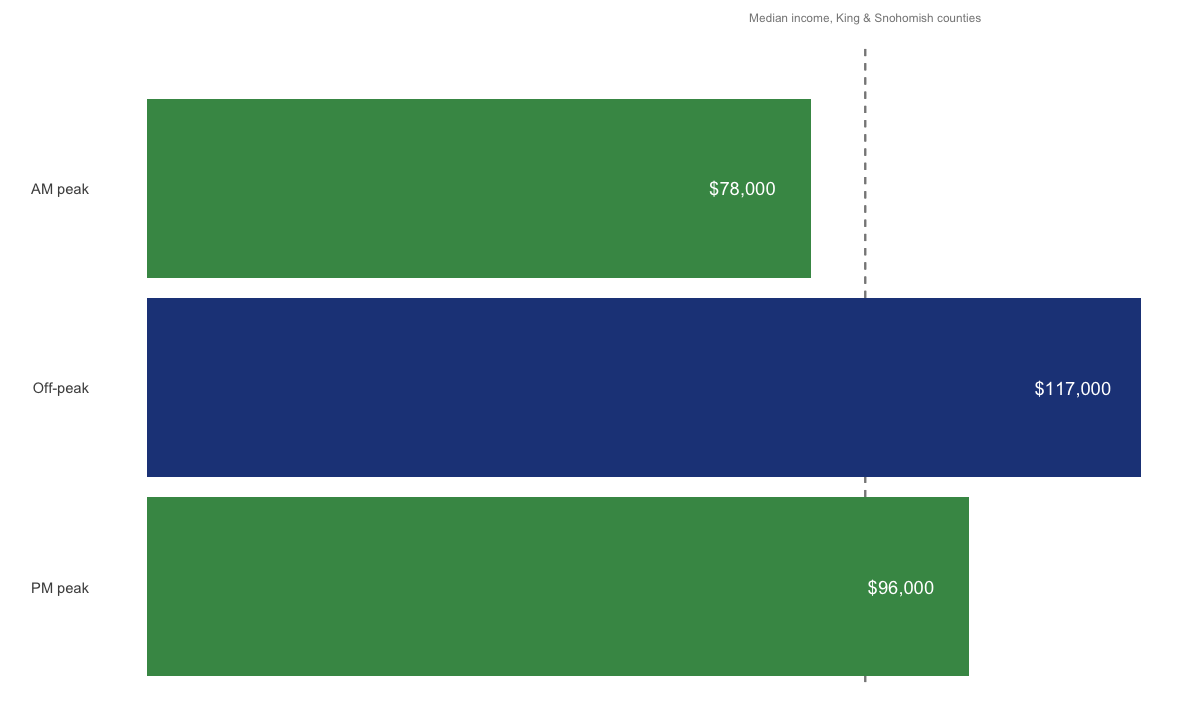

In [205]:
trips.2pct %>%
    filter(commercial==0, is_hov==0) %>%
    mutate(hour = hour(entry_time),
           direction = ifelse(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak",
                             pm_peak & direction=="NB" ~ "PM peak",
                             T ~ "Off-peak")) %>%
    block_counts_by(group, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    mutate(peak=c(T, F, T)) %>%
ggplot(aes(fct_rev(group), est_50)) +
    geom_segment(x=3.7, xend=0.5, y=1e3*median(fit_metro), yend=1e3*median(fit_metro),
                 lty="dashed", color="#888888") +
    geom_col(aes(fill=peak)) + 
    scale_fill_manual(values=c("#224488", "#449555")) +
    geom_text(aes(label=scales::dollar(round(est_50/1000)*1000)), color="white", nudge_y=-8e3) +
    labs(x="") + guides(fill=F) +
    coord_flip() +
    annotate("text", label="\nMedian income, King & Snohomish counties", 
             x=3.9, y=1e3*(median(fit_metro)), hjust="center", size=2.5, color="#888888") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank())

ggsave("../../../img/inc_peak.png", height=3, width=6.5, dpi=320)

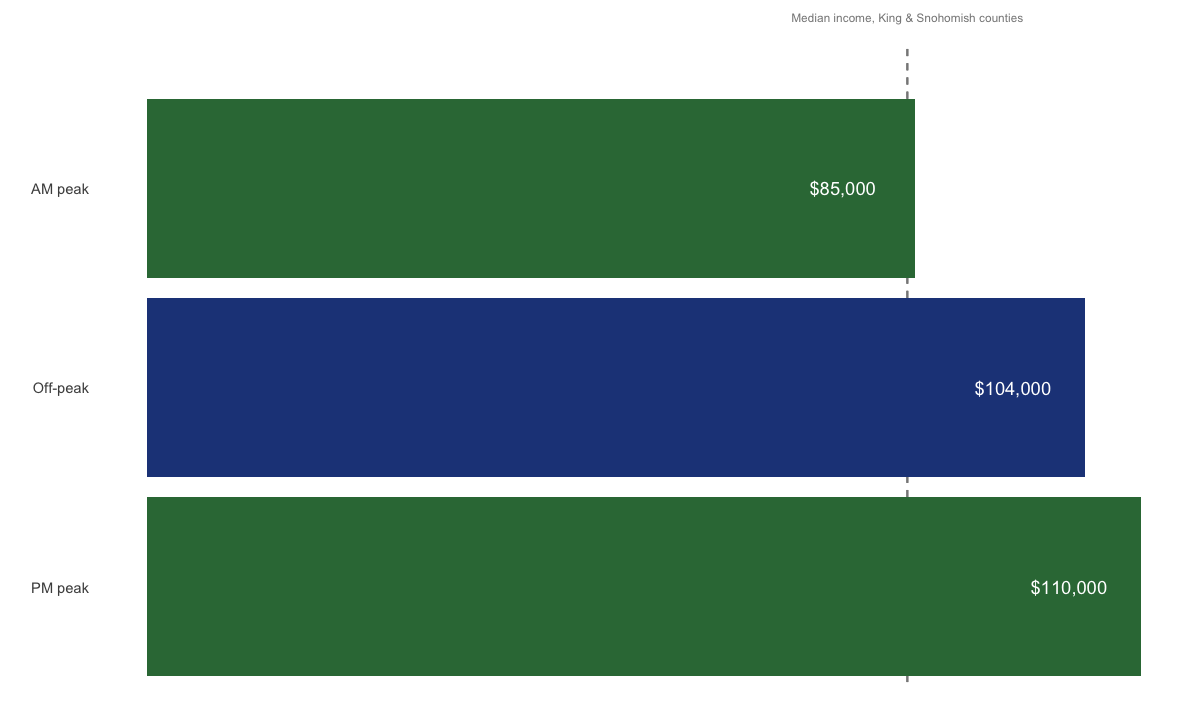

In [177]:
trips.2pct %>%
    filter(commercial==0, is_hov==0) %>%
    mutate(hour = hour(entry_time),
           direction = ifelse(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak ~ "AM peak",
                             pm_peak ~ "PM peak",
                             T ~ "Off-peak")) %>%
    block_counts_by(group, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    mutate(peak=c(T, F, T)) %>%
ggplot(aes(fct_rev(group), est_50)) +
    geom_segment(x=3.7, xend=0.5, y=1e3*median(fit_metro), yend=1e3*median(fit_metro),
                 lty="dashed", color="#888888") +
    geom_col(aes(fill=peak)) + 
    scale_fill_manual(values=c("#224488", "#337744")) +
    geom_text(aes(label=scales::dollar(round(est_50/1000)*1000)), color="white", nudge_y=-8e3) +
    labs(x="") + guides(fill=F) +
    coord_flip() +
    annotate("text", label="\nMedian income, King & Snohomish counties", 
             x=3.9, y=1e3*(median(fit_metro)), hjust="center", size=2.5, color="#888888") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank())

ggsave("../../../img/inc_peak_2.png", height=3.5, width=6.5, dpi=320)

In [437]:
peak.m = trips.2pct %>%
    filter(commercial==0, is_hov==0) %>%
    mutate(hour = hour(entry_time),
           direction = ifelse(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak SB",
                             pm_peak & direction=="NB" ~ "PM peak NB",
                             am_peak & direction=="NB" ~ "Reverse\ncommute",
                             pm_peak & direction=="SB" ~ "Reverse\ncommute",
                             T ~ "Off-peak")) %>%
    block_counts_by(group, acs) %>%
    fit_ecolg(vary_slopes=F)

N = 50000
fit.d = tibble(hh_income = rinc(N*4, fit_all)/1e3,
               tract = "all")
fit.d$group = rep(c("AM peak SB", "PM peak NB", "Off-peak", "Reverse\ncommute"), N)
fit.d$count = exp(predict(peak.m, newdata=fit.d, allow.new.levels=T))

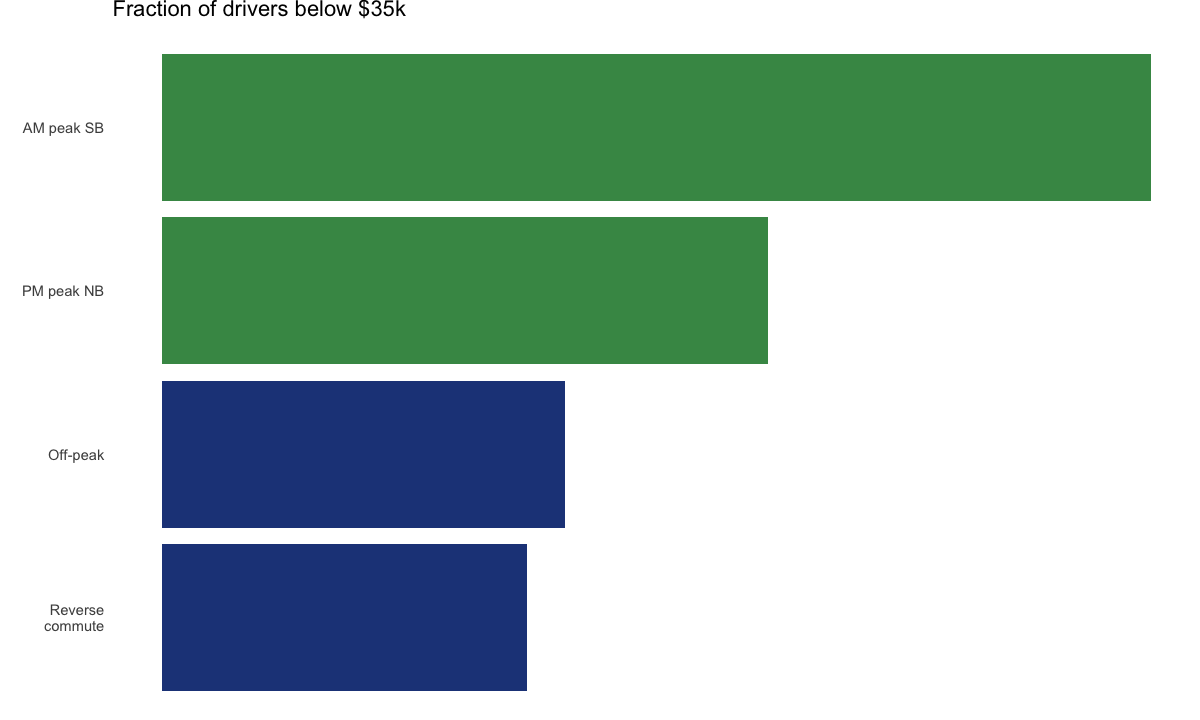

In [450]:
fit.d %>%
    group_by(group) %>%
    summarize(pct_lowinc = weighted.mean(hh_income < 35/1e3, count)) %>%
    mutate(peak = group %in% c("AM peak SB", "PM peak NB"),) %>%
ggplot(aes(fct_reorder2(group, -peak, -pct_lowinc), pct_lowinc)) + 
    geom_col(aes(fill=peak)) + 
    scale_fill_manual(values=c("#224488", "#449555")) +
    #geom_text(aes(label=scales::percent(pct_lowinc)), color="white", nudge_y=-0.02) +
    labs(x="") + guides(fill=F) +
    ggtitle("Fraction of drivers below $35k") +
    coord_flip() +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          plot.margin = grid::unit(c(0,0,0,0), "mm"))

#ggsave("../../../img/lowinc_peak.png", height=3, width=6.5, dpi=320)
ggsave("../../../img/lowinc_peak.png", height=3, width=3.25, dpi=320)

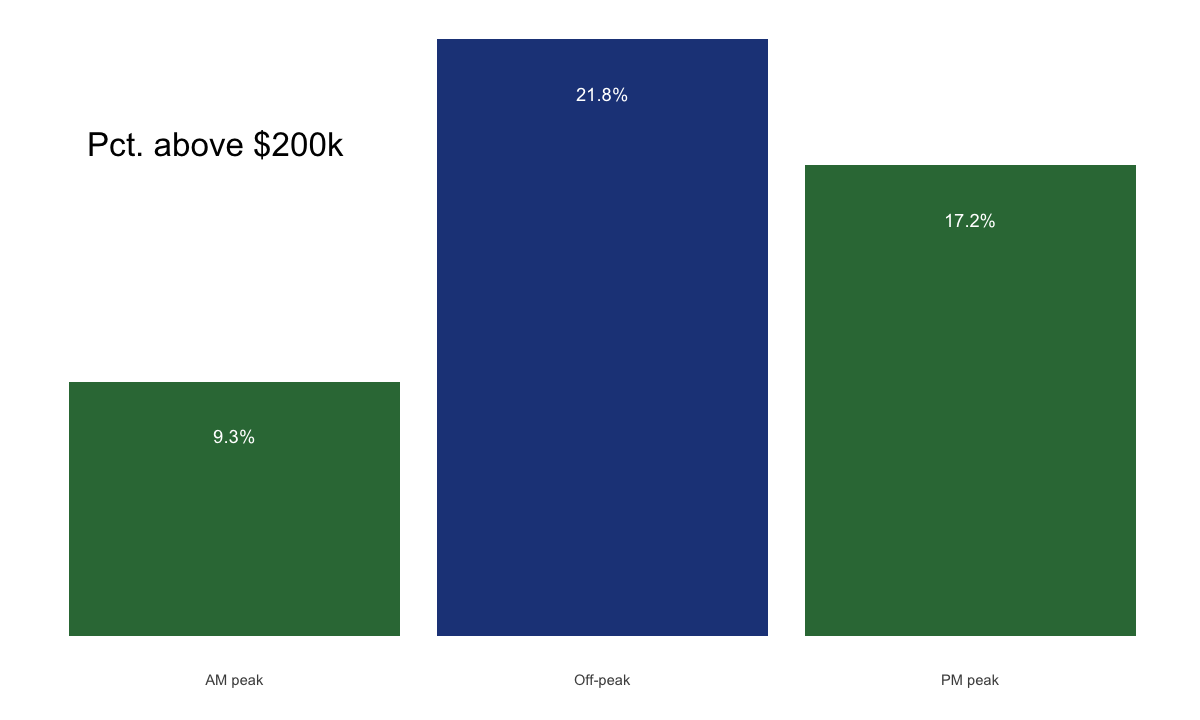

In [70]:
fit.d %>%
    group_by(group) %>%
    summarize(pct_lowinc = weighted.mean(hh_income > 200/1e3, count)) %>%
    mutate(peak = !group == "Off-peak") %>%
ggplot(aes(group, pct_lowinc)) + 
    geom_col(aes(fill=peak)) + 
    scale_fill_manual(values=c("#224488", "#337744")) +
    geom_text(aes(label=scales::percent(pct_lowinc)), color="white", nudge_y=-0.02) +
    labs(x="") + guides(fill=F) +
    annotate("text", label="Pct. above $200k", x=0.6, y=0.18, hjust="left", size=7) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())

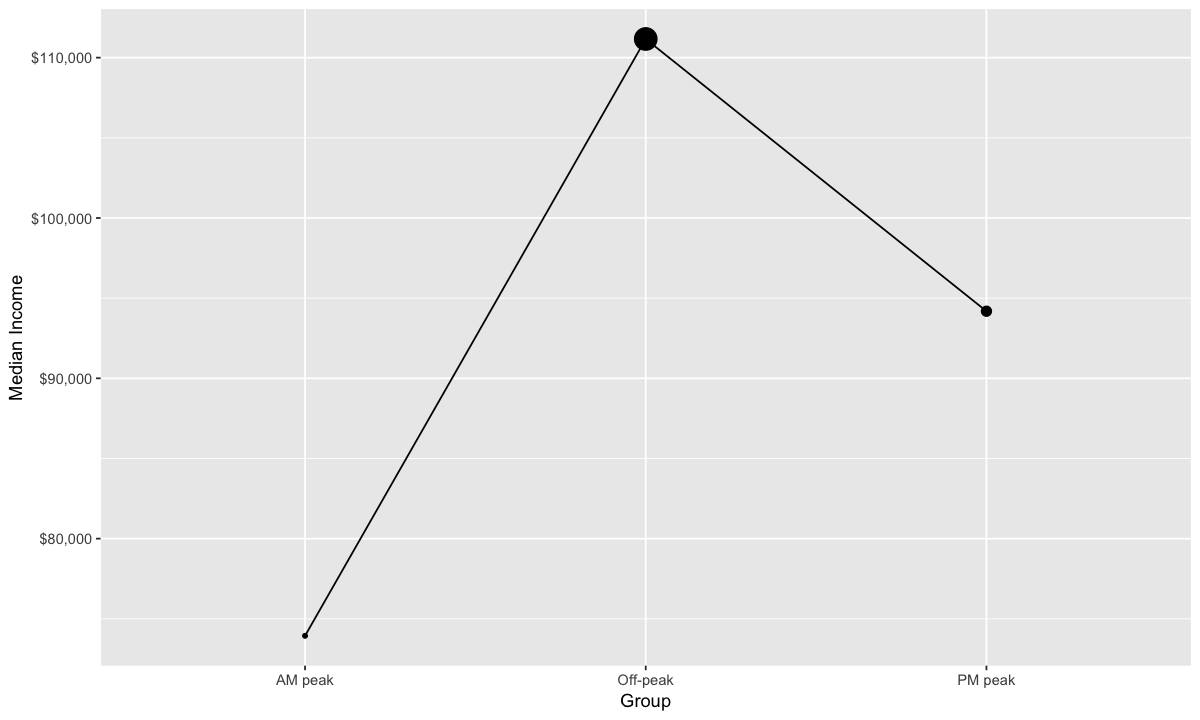

In [18]:
trips.2pct %>%
    mutate(hour = hour(entry_time),
           direction = ifelse(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak",
                             pm_peak & direction=="NB" ~ "PM peak",
                             T ~ "Off-peak")) %>%
    block_counts_by(group, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(c(0.1, 0.25, 0.5, 0.75, 0.9), fit_all) %>% 
    plot_med_inc

In [333]:
plaza_dist = read_csv("../../data/milepost_lookups/plaza_dist.csv", col_types="cid")

In [334]:
mp_annotations = tribble(
    ~direction, ~mp, ~plaza, ~label,
    "NB", 0, 1, "Bellevue",
    "NB", 2.9, 3.1, "NE 70th",
    "NB", 5, 4, "NE 116th",
    "NB", 6.7, 6, "NE 128th DAR",
    "NB", 9.5, 7.3, "SR 522",
    "NB", 12.5, 8.2, "SR 527",
    "NB", 15.4, 10, "I-5",
    "SB", 0, 1, "I-5",
    "SB", 2, 2.4, "SR 527",
    "SB", 4.5, 3.5, "SR 522",
    "SB", 7.8, 7, "NE 128th DAR",
    "SB", 9.5, 7.8, "NE 85th",
    "SB", 13, 9.5, "SR 520",
    "SB", 14.9, 10, "Bellevue",
)

ann_nb = filter(mp_annotations, direction=="NB")
ann_sb = filter(mp_annotations, direction=="SB")

In [344]:
route_vols = trips.2pct %>%
    filter(commercial == 0, is_hov == 0) %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = if_else(am_peak, "AM", if_else(pm_peak, "PM", "Off")),
           id = str_glue("{direction}_{entry}_{exit}")) %>%
    block_counts_by(id, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all) %>%
    separate(id, c("direction", "entry", "exit"), remove=F, convert=T) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)

In [345]:
route_vols

id,direction,entry,exit,est_50,count,entry_mp,exit_mp,trip_dist
<fct>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NB_1_1,NB,1,1,101936.94,8708.649,0.0,0.0,0.0
NB_1_10,NB,1,10,81042.81,14279.713,0.0,15.4,15.4
NB_1_3,NB,1,3,119881.51,13111.010,0.0,2.9,2.9
NB_1_4,NB,1,4,105521.11,13604.196,0.0,6.0,6.0
NB_1_5,NB,1,5,99915.16,10385.767,0.0,6.7,6.7
NB_1_7,NB,1,7,100376.09,9434.109,0.0,8.3,8.3
NB_1_8,NB,1,8,79837.76,8998.747,0.0,12.1,12.1
NB_1_9,NB,1,9,89391.69,6714.073,0.0,14.3,14.3
NB_10_10,NB,10,10,81332.72,5990.609,15.4,15.4,0.0


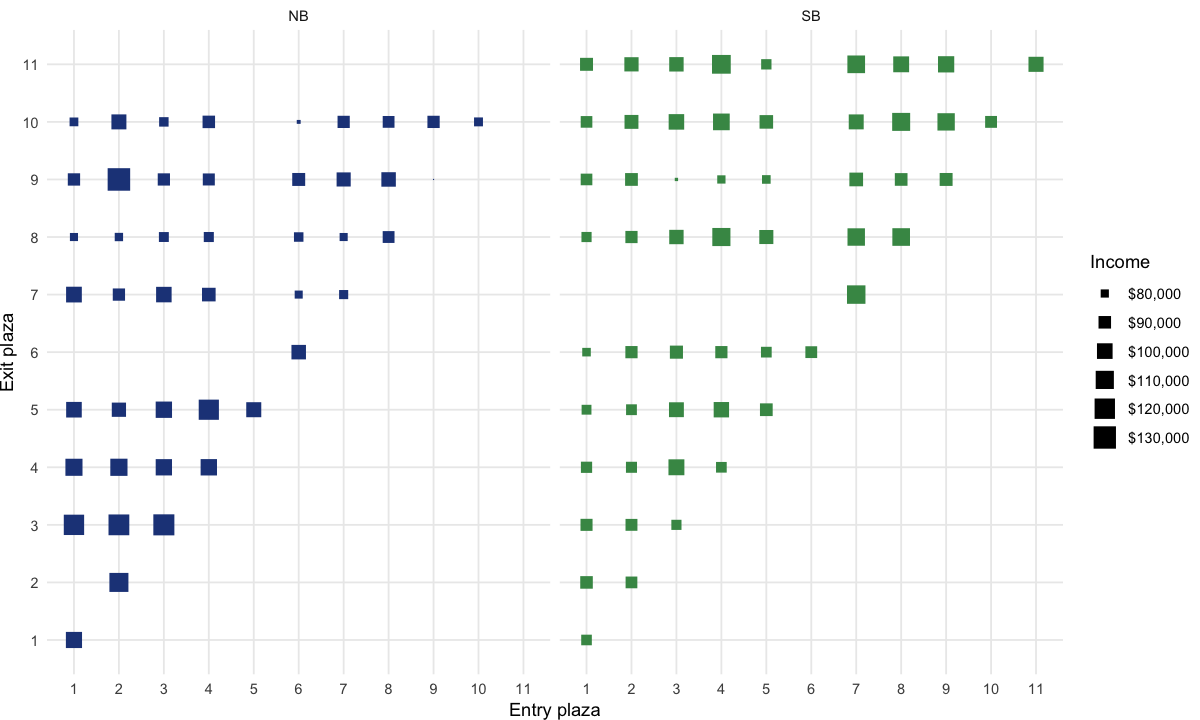

In [346]:
route_vols %>%
    #filter(peak_group != "Off") %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=direction, size=est_50)) +
    facet_wrap("direction") +
    #facet_grid(peak_group ~ direction) +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#449555")) +
    scale_size_continuous(labels=scales::dollar, range=c(0, 6)) +
    guides(color=F) +
    labs(size="Income", color="", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))


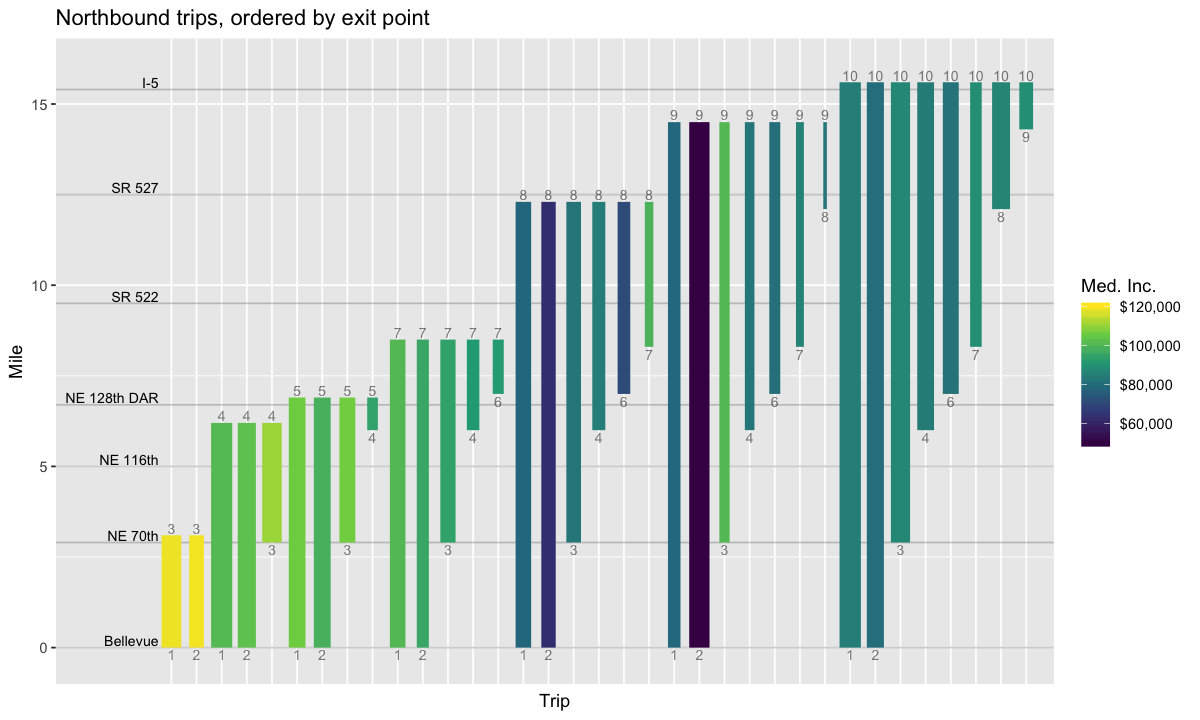

In [120]:
filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=count, color=est_50)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar, limits=c(50e3, 120e3), oob=scales::squish) + 
    labs(title="Northbound trips, ordered by exit point", x="Trip", y="Mile", color="Med. Inc.")

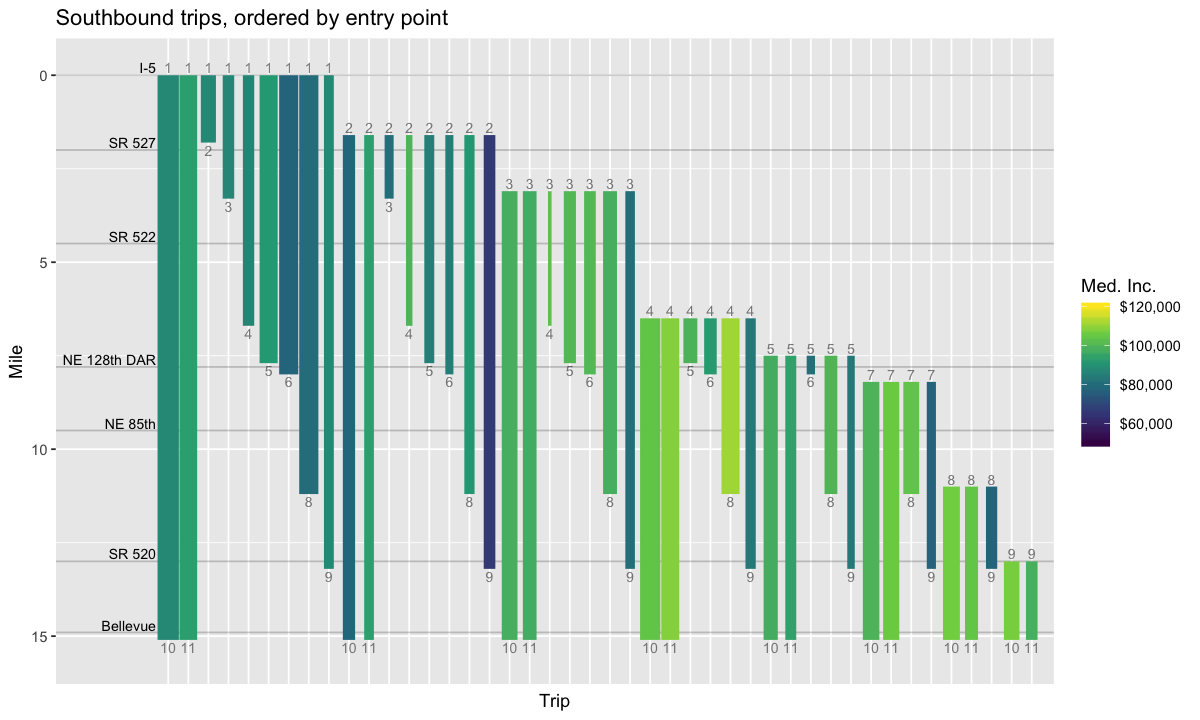

In [121]:
filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=count, color=est_50)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar, limits=c(50e3, 120e3), oob=scales::squish) + 
    scale_y_reverse() +
    labs(title="Southbound trips, ordered by entry point", x="Trip", y="Mile", color="Med. Inc.")